# Advanced EDA and Baseline Modelling

### Rishane Dassanayake

## Table of Contents

- [Introduction](#introduction)
- [Basic Setup](#basic_setup)
- [Feature Engineering](#feature_engineering)
- [Advanced EDA](#advanced_eda)
- [Modelling](#modelling)
  - [Train-Test Split/Scaling](#split_scaling)
  - [Logistic Regression](#logistic_regresion)
    - [Logistic Regression Model 1: Baseline Model](#lr1)
    - [Logistic Regression Model 2: Treatments + Essential Control Variables](#lr2)
    - [Logistic Regression Model 3: All Variables](#lr3)
    - [Logistic Regression Model 4 & 5: Eliminating Problematic Features and SelectKBest](#lr4/5)
    - [Logistic Regression Model 6: SMOTE](#lr6)
    - [Logistic Regression Model 7: GridSearchCV](#lr7)
    - [Logistic Regression Model Summaries](#lr_summary)
  - [Decision Tree](#decision_tree)
  - [Random Forest](#random_forest)
    - [Random Forest Model 1: First Pass](#rf1)
    - [Random Forest Model 2: Tuned Model](#rf2)
  - [Gradient Boosting](#gradient_boosting)
  - [Neural Network](#neural_network)
- [Conclusions](#conclusions)
- [Appendix](#appendix)

## Introduction <a id="introduction"></a>

This notebook contains the advanced EDA and baseline modelling components of my Capstone project for the BrainStation Data Science bootcamp. 

**Research Question**

This project is aimed at answering the question: **'How might we use machine learning to understand the role of social pressure in influencing voting behaviour?'.**

**Data**

The dataset I have used comes from a paper published in 2008 by Donald P. Green, Alan S. Gerber and Christopher W. Larimer called "Social Pressure and Voter Turnout: Evidence from a Large-Scale Field Experiment". The paper contains a sample size of 344,084 individuals (registered voters) and 180,002 households in the U.S. state of Michigan. 

The paper reports results of a field experiment whereby the experimenters sent mail to households that were randomly assigned to one of 4 treatment group. Each treatment group received mail containing one of 4 different prompts with each prompt escalating in the degree of social pressure they exert on the recipient to vote in the upcoming 2006 Michigan Primary Election. The paper then measures whether each individual voted in the election. The dataset also contains data on each individual's previous voting behaviour and census data from the United States Census Bureau that describes demographic, employment and educational information for each ZIP code studied in the paper. 

I have included a data dictionary in the [appendix](#appendix).

One note on the **level of granularity** of our dataset: each rows contains data about the treatment status of an individual (`treatment`), whether or not they voted in the 2006 Primary Election (`voted`) and other details. Each row also contains census data about the demographic characteristics of the ZIP code in which the individual resides. Given that we have a satisfactory understanding of the data (excluding a few columns), we can move on to performing some basic EDA. 

> The aim of this project is to use machine learning to identify the effect of each of the treatments on voting behaviour and find subgroups in the population that responded particularly strongly to the treatments. 

Follow [this link](https://drive.google.com/drive/folders/1UqjmiWH4Zvxt3b-Ve2yyaAsAzuwhuxI4?usp=sharing) to access all the datasets used in this project. 

**Structure**

This notebook is structured into three main sections. Section 1 deals with feature engineering. Section 2 deals with advanced EDA and Section 2 contains my modelling approaches. 

**References**

Gerber, Alan S., Donald P. Green, and Christopher W. Larimer, 2008, Replication Materials for “Social Pressure and Voter Turnout: Evidence from a Large-Scale Field Experiment.” http://hdl.handle.net/10079/c7507a0d-097a-4689-873a-7424564dfc82. ISPS Data Archive.

Census Data Source: https://data.census.gov/all?g=040XX00US26&y=2011

## Basic Setup <a id="basic_setup"></a>

We can begin by importing the majority of the libraries we will be using in this notebook.

In [2]:
# importing libraries
import sys
sys.path.append('utils/')
import capstone_utils as u

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

Next, we can set our dataframe options, and load/display our data. 

In [3]:
# show all dataframe columns
pd.set_option('display.max_columns', None)

In [4]:
# load the data
data_original = pd.read_csv('~/Desktop/social_clean.csv', low_memory=False, index_col = 0)

In [5]:
display(data_original.head())
print(data_original.shape)

,sex,yob,g2000,g2002,g2004,p2000,p2002,p2004,treatment,cluster,voted,votedav,dem,nov,aug,zip,plus4,city,hh_id,hh_size,CityName,totalpopulation_estimate,percent_male,percent_female,median_age,percent_under5years,percent_5to9years,percent_10to14years,percent_15to19years,percent_20to24years,percent_25to34years,percent_35to44years,percent_45to54years,percent_55to59years,percent_60to64years,percent_65to74years,percent_75to84years,percent_85yearsandolder,percent_18yearsandolder,percent_21yearsandover,percent_62yearsandover,percent_65yearsandover,percent_white,percent_black,percent_amindian_alaskan,percent_asian,percent_nativeandother,percent_other_nativeandother,percent_hispanicorlatino,percent_race_other,median_income,mean_income,employ_16,unemploy_16,unemploy_20to64,employ_20to64,employ_rename_20to64,hsorhigher,bach_orhigher,less9thgrade,grade9to12,highschool,somecollege,assoc,bachelors,grad,age
0,1,1918,1,1,1,0,1,0,control,4,0,0,43,70,72,48001,1022,13,61,1,Algonac,12192,50.1,49.9,45.4,5.3,4.2,6.8,5.3,6.5,10.3,10.8,18.9,7.4,8.9,9.6,4.6,1.3,80.1,76.6,20.6,15.5,98.8,0.0,0.4,0.5,0.0,0.2,1.5,0.6,48081,58309,48.3,16.2,15.8,59.6,3.5,87.8,16.0,2.2,10.1,37.2,27.7,6.8,9.8,6.2,88
1,0,1953,1,1,1,1,1,1,control,8,1,0,1,99,99,48001,4131,2,141,2,Algonac,12192,50.1,49.9,45.4,5.3,4.2,6.8,5.3,6.5,10.3,10.8,18.9,7.4,8.9,9.6,4.6,1.3,80.1,76.6,20.6,15.5,98.8,0.0,0.4,0.5,0.0,0.2,1.5,0.6,48081,58309,48.3,16.2,15.8,59.6,3.5,87.8,16.0,2.2,10.1,37.2,27.7,6.8,9.8,6.2,53
2,0,1927,1,1,1,0,1,0,neighbors,17,0,0,0,86,29,48001,3002,1,300,2,Algonac,12192,50.1,49.9,45.4,5.3,4.2,6.8,5.3,6.5,10.3,10.8,18.9,7.4,8.9,9.6,4.6,1.3,80.1,76.6,20.6,15.5,98.8,0.0,0.4,0.5,0.0,0.2,1.5,0.6,48081,58309,48.3,16.2,15.8,59.6,3.5,87.8,16.0,2.2,10.1,37.2,27.7,6.8,9.8,6.2,79
3,1,1953,1,1,1,0,0,1,control,6,0,0,6,89,30,48001,3321,1,101,4,Algonac,12192,50.1,49.9,45.4,5.3,4.2,6.8,5.3,6.5,10.3,10.8,18.9,7.4,8.9,9.6,4.6,1.3,80.1,76.6,20.6,15.5,98.8,0.0,0.4,0.5,0.0,0.2,1.5,0.6,48081,58309,48.3,16.2,15.8,59.6,3.5,87.8,16.0,2.2,10.1,37.2,27.7,6.8,9.8,6.2,53
4,0,1984,0,1,1,0,0,0,hawthorne,2,0,0,9,75,2,48001,1644,6,35,3,Algonac,12192,50.1,49.9,45.4,5.3,4.2,6.8,5.3,6.5,10.3,10.8,18.9,7.4,8.9,9.6,4.6,1.3,80.1,76.6,20.6,15.5,98.8,0.0,0.4,0.5,0.0,0.2,1.5,0.6,48081,58309,48.3,16.2,15.8,59.6,3.5,87.8,16.0,2.2,10.1,37.2,27.7,6.8,9.8,6.2,22


(344084, 67)


Our cleaned dataset contains 344,084 rows and 67 columns. Each row represents information for a single individual in our dataset. The dataset includes information about their past voting behaviour, current voting behaviour (target column), what treatment they received (main feature column(s)) and a variety of demographic indicators that are gathered at the block level. The next section, [Feature Engineering](#feature_engineering), is where I prepare the dataset for modelling. 

In [130]:
# create copy of data to work with 
data = data_original.copy()

## Feature Engineering <a id="feature_engineering"></a>

The goals of this section are twofold: 
1. To one-hot encode my treatment column which is currently included as an 'object' datatype.
2. To drop columns that contain information that is i) redundant, ii) lacking in variance and/or iii) prone to causing issues related to multicolinearity. 

### One-Hot Encoding Treatment Column

In [131]:
# redefine dataframe after converting treatment column to dummies
data = pd.get_dummies(data, columns=['treatment'], dtype='int')

In [132]:
# sense-check 
data.columns

Index(['sex', 'yob', 'g2000', 'g2002', 'g2004', 'p2000', 'p2002', 'p2004',
       'cluster', 'voted', 'votedav', 'dem', 'nov', 'aug', 'zip', 'plus4',
       'city', 'hh_id', 'hh_size', 'CityName', 'totalpopulation_estimate',
       'percent_male', 'percent_female', 'median_age', 'percent_under5years',
       'percent_5to9years', 'percent_10to14years', 'percent_15to19years',
       'percent_20to24years', 'percent_25to34years', 'percent_35to44years',
       'percent_45to54years', 'percent_55to59years', 'percent_60to64years',
       'percent_65to74years', 'percent_75to84years', 'percent_85yearsandolder',
       'percent_18yearsandolder', 'percent_21yearsandover',
       'percent_62yearsandover', 'percent_65yearsandover', 'percent_white',
       'percent_black', 'percent_amindian_alaskan', 'percent_asian',
       'percent_nativeandother', 'percent_other_nativeandother',
       'percent_hispanicorlatino', 'percent_race_other', 'median_income',
       'mean_income', 'employ_16', 'unemploy_16

### Drop Columns

In this section, we aim to identify 'bad' columns and remove them from our dataset. These are columns that are: 
1. **Redundant**
2. **Lacking in Variance**
3. **Collinear**

Removing these columns may help our modelling approach by improving model performance, reducing overfitting and improving interpretability. 

**Identifying Redundant Columns**

These are columns that add no information/add noise to our dataset for reasons unrelated to a lack of variance. Obvious examples of these kinds of columns are our identifier columns (e.g. `zip`, `city`, `hh_id`). These columns only exist in our dataset to identify and categorise our data. Including redundant features in a dataset can lead to wasted computational resources since these features do not add new information. Also, since this model interpretability is crucial for this analysis, redundant features can also obscure the understanding of how input variables relate to the output. Therefore, they can be removed.

In [133]:
# drop identifier columns
data = data.drop(columns=['cluster', 'zip', 'plus4', 'city', 'hh_id', 'CityName'])

**Examining Column Variance**

We need to examine the variance of each of our columns in order to determine whether they contain meaningful information that could help us distinguish between observations. This is important because features with little to no variance do not contribute to a model's ability to predict the target variable. Including them can unnecessarily increase the complexity of the model and the computational cost. In order to accurately assess the variance of columns, we need to first scale our data to ensure that the scale of any given column doesn't lead to us overrepresenting the variance of said column. 

In [134]:
# separate features
features = data.drop(columns=['voted', 'votedav'])

# instantiate scaler, fit and transform 
fe_ss = StandardScaler()
features_scaled = fe_ss.fit_transform(features)

# convert back to dataframe
features_scaled_df = pd.DataFrame(features_scaled, columns=features.columns)

# import VarianceThreshold library
from sklearn.feature_selection import VarianceThreshold

# apply VarianceThreshold
vt = VarianceThreshold(threshold=0.9)
selected_features = vt.fit_transform(features_scaled_df)

# check which features have been eliminated
eliminated_features = features.columns[~vt.get_support()]
print(eliminated_features)

Index(['g2004'], dtype='object')


Our VarianceThreshold object has identified 1 column that has a variance lower than a threshold of 0.9 - `g2004`. In fact, this column has a variance of 0 and only has a value of 1. This is because potential participants who did not vote in the 2004 General Election, an election for which voter turnout was very high, were not included in the study as they were deemed to be 'deadwood' voters (i.e. voters who had moved out of state, changed address, incarcerated or otherwise incapable of voting in the 2006 Primary Election). We can therefore proceed with dropping this column. 

In [135]:
# check value counts for g2004
data['g2004'].value_counts()

g2004
1    344084
Name: count, dtype: int64

In [136]:
# drop g2004 because no variance
data.drop(columns=['g2004'], inplace=True)

**Collinear Features**

These are features that are highly linearly correlated with each other. They are important to identify and drop as they can cause issues in model estimation, including making the model sensitive to small changes in the data, which leads to high variance in coefficient estimates for the collinear variables. This can complicate the interpretation of the model's output, as it becomes challenging to discern the effect of each feature on the target variable. We can identify these variables by checking for pairs of highly correlated features in our dataset using a custom-built function.

In [137]:
u.find_correlated_pairs(features.corr(), threshold=0.8)

[('yob', 'age', -1.0000000000000004),
 ('percent_male', 'percent_female', -1.0),
 ('percent_5to9years', 'percent_18yearsandolder', -0.8065072210913813),
 ('percent_65to74years', 'percent_62yearsandover', 0.8902163511302312),
 ('percent_65to74years', 'percent_65yearsandover', 0.8755486829635939),
 ('percent_75to84years', 'percent_62yearsandover', 0.865892674383772),
 ('percent_75to84years', 'percent_65yearsandover', 0.8967826032711832),
 ('percent_18yearsandolder', 'percent_21yearsandover', 0.8068703587930822),
 ('percent_62yearsandover', 'percent_65yearsandover', 0.9852387260835322),
 ('percent_white', 'percent_black', -0.8577569184221611),
 ('percent_hispanicorlatino', 'percent_race_other', 0.9112161601953078),
 ('median_income', 'mean_income', 0.9587222108020982),
 ('mean_income', 'bach_orhigher', 0.8492016851032611),
 ('mean_income', 'bachelors', 0.8022047561544401),
 ('mean_income', 'grad', 0.8332491021102572),
 ('employ_16', 'employ_20to64', 0.9200344862921447),
 ('unemploy_16', '

**Age/Gender Columns**: We can drop `yob` as this is perfectly negatively correlated with `age` (by construction). Similarly, we can drop `percent_male`. For the remaining age columns, many of these feature columns are highly correlated because they represent overlapping age groups (e.g `percent_65to74years` is a subset of `percent_65yearsandover`). We can choose age groupings that are mutually exclusive and collectively exhaustive - `percent_under18years`, `percent_18to64years`, `percent_65yearsandover`. 

In [138]:
# drop yob because age is already included
data = data.drop(columns=['yob'])

# drop percent_male
data = data.drop(columns=['percent_male'])

In [139]:
# create 'percent_under18years' column
data['percent_under18years'] = 100 - data['percent_18yearsandolder']

# create 'percent_18to64years'
data['percent_18to64years'] = 100 - (data['percent_under18years'] + data['percent_65yearsandover'])

# drop unnecessary age columns - we only want <18, 18-64, >65, 
data = data.drop(columns = ['percent_under5years', 'percent_5to9years', 'percent_10to14years', 'percent_15to19years',
                            'percent_20to24years', 'percent_25to34years', 'percent_35to44years',
                            'percent_45to54years', 'percent_55to59years', 'percent_60to64years',
                            'percent_65to74years', 'percent_75to84years', 'percent_85yearsandolder',
                            'percent_18yearsandolder', 'percent_21yearsandover','percent_62yearsandover'])

**Race Columns**: The strong inverse correlation between `percent_white` and `percent_black` indicate that there is likely strong racial segmentation between ZIP codes. This is presumably because Michigan has a predominantly white population, so increases in `percent_white` mechanically reduce the percentage of people of other races. However, despite this strong correlation betweeen race columns, I think this information is valuable to preserve, especially if we are interested in identifying subgroups in the population. For linear models like logistic regression that are particularly sensitive to multicollinearity, we can remove these columns at the modelling stage.

**Employment/Education Columns**: Mean and median income are highly correlated as both are aggregate measures of income status. Whereas mean income is more sensitive to outliers, median income is more robust. Therefore, we can drop `mean_income`. Furthermore, income and education levels are highly correlated. This is to be expected. Also, measures that deal with overlapping categories (as addressed earlier) are naturally correlated. We can deal with this by only retaining unemployment measures (not employment) and education columns that just address what proportion of the population has `bachelors_orhigher` and `less_9thgrade` education. 

In [140]:
# drop mean_income
data = data.drop(columns=['mean_income'])

# drop unnecessary employment columns - we only unemployment
data = data.drop(columns=['employ_rename_20to64', 'employ_16', 'unemploy_20to64', 'employ_20to64'])

# drop unnecessary education columns - we want just bachelors or higher and less 9thgrade
data = data.drop(columns=['grade9to12', 'somecollege', 'assoc', 'grad', 'bachelors', 'hsorhigher'])

#### Other features

I have chosen to drop `nov` and `aug`. I am currently unsure what exactly these columns capture. Following my preliminary EDA, my working hypothesis is that these columns refer to a probability that an individual voted in November or August which correspond to General and Primary elections in Michigan, respectively. Some of this premliminary EDA is included in the [appendix](#appendix). Since my binary columns `g2002`, `p2002` etc. already capture much of this information and I am uncertain about the true interpretation of `nov` and `aug`, keeping these columns seems to be unnecessary and may complicate my model interpretation.

In [141]:
# drop aug and nov
data = data.drop(columns = ['nov', 'aug'])

This concludes the feature engineering section of this analysis. At the end of this section, we are left with 35 columns. We can now move on to the [Advanced EDA](#advanced_eda) section of this notebook. 

In [142]:
# check .info() for an overview of remaining columns
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 344084 entries, 0 to 344083
Data columns (total 35 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   sex                           344084 non-null  int64  
 1   g2000                         344084 non-null  int64  
 2   g2002                         344084 non-null  int64  
 3   p2000                         344084 non-null  int64  
 4   p2002                         344084 non-null  int64  
 5   p2004                         344084 non-null  int64  
 6   voted                         344084 non-null  int64  
 7   votedav                       344084 non-null  int64  
 8   dem                           344084 non-null  int64  
 9   hh_size                       344084 non-null  int64  
 10  totalpopulation_estimate      344084 non-null  int64  
 11  percent_female                344084 non-null  float64
 12  median_age                    344084 non-null  fl

## Advanced EDA <a id="advanced_eda"></a>

This section aims to expand on the EDA performed in the previous notebook. Specifically, the goal of advanced EDA is to gain further insights that may be relevant for modelling and to explore what possible subgroups could exist within our population dataset. 

### Examining Class Imbalance

One essential aspect of our data that needs to be examined in the class imbalance in our target column. As shown below, our class imbalance is moderately severe - 68.4% of people in our dataset are non-voters and 31.6% are voters. This means that the lower bound on the usefulness of our model is an accuracy score of 68.4%. This is the accuracy of a model that merely predicts the majority class each time. Any model we build will therefore be compared against this baseline level of accuracy, in addition to using other metrics like precision, recall, f1 score and ROC/AUC. 

In [32]:
# check value counts of our target column
data['voted'].value_counts(normalize=True)

voted
0    0.6841
1    0.3159
Name: proportion, dtype: float64

### Cluster Analysis

This sub-section aims to use an unsupervised learning approach - clustering - to identify subgoups in our population that might indicate different levels of responsiveness to treatments. Clustering algorithms group data points based on feature similarity. This may reveal previously unnoticed patterns, similarities, or disparities within the data, which might not be evident through standard statistical analysis.

#### Scaling

Before performing our clustering analysis using MiniBatchKmeans, we first scale our data. This is important because clustering algorithms like K-Means use distance measures that are sensitive to the scale of the data.

In [112]:
# define cluster data
cluster_df = data

# instantiate, fit and transform cluster_df
cluster_ss = StandardScaler()
cluster_scaled = cluster_ss.fit_transform(cluster_df)
cluster_df_scaled = pd.DataFrame(data = cluster_df, columns = cluster_df.columns)
cluster_df_scaled

,sex,g2000,g2002,p2000,p2002,p2004,dem,hh_size,totalpopulation_estimate,percent_female,median_age,percent_65yearsandover,percent_white,percent_amindian_alaskan,percent_asian,percent_nativeandother,percent_hispanicorlatino,percent_race_other,median_income,mean_income,unemploy_16,bach_orhigher,less9thgrade,highschool,age,treatment_civic duty,treatment_hawthorne,treatment_neighbors,treatment_self,percent_under18years,percent_18to64years
0,1.001437,0.431905,0.482337,-0.580031,1.251067,-0.819052,1.035219,-1.497075,-0.664664,-0.347715,1.251605,0.436818,0.788512,-0.498666,-0.559083,-0.483588,-0.567531,-0.376763,-0.663212,-0.688799,1.937839,-0.911727,-0.281247,0.836438,2.644713,-0.353483,-0.353410,-0.353394,-0.353483,-1.334752,0.885125
1,-0.998565,0.431905,0.482337,1.724047,1.251067,1.220924,-1.018952,-0.232413,-0.664664,-0.347715,1.251605,0.436818,0.788512,-0.498666,-0.559083,-0.483588,-0.567531,-0.376763,-0.663212,-0.688799,1.937839,-0.911727,-0.281247,0.836438,0.222413,-0.353483,-0.353410,-0.353394,-0.353483,-1.334752,0.885125
2,-0.998565,0.431905,0.482337,-0.580031,1.251067,-0.819052,-1.067860,-0.232413,-0.664664,-0.347715,1.251605,0.436818,0.788512,-0.498666,-0.559083,-0.483588,-0.567531,-0.376763,-0.663212,-0.688799,1.937839,-0.911727,-0.281247,0.836438,2.021836,-0.353483,-0.353410,2.829699,-0.353483,-1.334752,0.885125
3,1.001437,0.431905,0.482337,-0.580031,-0.799318,1.220924,-0.774407,2.296911,-0.664664,-0.347715,1.251605,0.436818,0.788512,-0.498666,-0.559083,-0.483588,-0.567531,-0.376763,-0.663212,-0.688799,1.937839,-0.911727,-0.281247,0.836438,0.222413,-0.353483,-0.353410,-0.353394,-0.353483,-1.334752,0.885125
4,-0.998565,-2.315326,0.482337,-0.580031,-0.799318,-0.819052,-0.627681,1.032249,-0.664664,-0.347715,1.251605,0.436818,0.788512,-0.498666,-0.559083,-0.483588,-0.567531,-0.376763,-0.663212,-0.688799,1.937839,-0.911727,-0.281247,0.836438,-1.923054,-0.353483,2.829574,-0.353394,-0.353483,-1.334752,0.885125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344079,1.001437,0.431905,0.482337,-0.580031,-0.799318,-0.819052,0.448313,-0.232413,-1.432881,-1.625741,0.300845,0.281770,0.788512,1.149068,-0.690046,-0.483588,-0.792644,-0.667528,-1.403814,-1.304876,3.498383,-1.036755,-0.452856,1.597981,0.845290,-0.353483,-0.353410,-0.353394,-0.353483,0.163494,-0.523902
344080,1.001437,0.431905,0.482337,1.724047,1.251067,-0.819052,1.964487,-0.232413,-1.432881,-1.625741,0.300845,0.281770,0.788512,1.149068,-0.690046,-0.483588,-0.792644,-0.667528,-1.403814,-1.304876,3.498383,-1.036755,-0.452856,1.597981,1.122124,2.828991,-0.353410,-0.353394,-0.353483,0.163494,-0.523902
344081,-0.998565,0.431905,0.482337,1.724047,1.251067,-0.819052,1.671034,-0.232413,-1.432881,-1.625741,0.300845,0.281770,0.788512,1.149068,-0.690046,-0.483588,-0.792644,-0.667528,-1.403814,-1.304876,3.498383,-1.036755,-0.452856,1.597981,1.122124,2.828991,-0.353410,-0.353394,-0.353483,0.163494,-0.523902
344082,-0.998565,0.431905,0.482337,-0.580031,1.251067,1.220924,0.986310,-0.232413,-1.432881,-1.625741,0.300845,0.281770,0.788512,1.149068,-0.690046,-0.483588,-0.792644,-0.667528,-1.403814,-1.304876,3.498383,-1.036755,-0.452856,1.597981,0.914498,-0.353483,-0.353410,-0.353394,-0.353483,0.163494,-0.523902


#### MiniBatchKMeans

This process involves looping over a range of possible k values where k is the number of clusters and generating inertia and silhouette scores for each value of k. Inertia refers to the sum of squared distances of samples to their closest cluster center. Silhouette score is a value that ranges from -1 to 1 where higher values indicate that datapoints are well-matched to their own cluster and poorly matched to neighbouring clusters. We can then examine inertia and silhouette scores. An ideal number of clusters can be identified using the elbow method for inertia score and the maximum value for silhouette scores. 

In [117]:
# check shape of scaled dataframe
df_scaled.shape

(344084, 31)

In [118]:
# create sample of dataframe for efficiency
sample = df_scaled.sample(frac=0.75, random_state=10)
sample.shape

(258063, 31)

In [119]:
# import libraries
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

In [120]:
# fitting k-means and picking best n_clusters

# define range for k values
k_range = list(range(2, 11))

# create empty lists to store inertia and silhouette scores
k_inertia_scores = []
k_sil_scores = []

# loop through values of k

for k in k_range:
    
    # instantiate model
    mbkmeans = MiniBatchKMeans(n_clusters = k, batch_size=1000, n_init='auto')

    # print
    print('model instantiated')

    # fit and get y labels
    y_labels = mbkmeans.fit_predict(sample)

    # print
    print('model fitted')

    # append inertia scores
    k_inertia_scores.append(mbkmeans.inertia_)

    print('inertia appended')

    # append silhouette scores
    k_sil_scores.append(silhouette_score(sample, y_labels))

    print('silhouette appended')

    # print progress update
    print(f'k={k} completed.')

model instantiated
model fitted
inertia appended
silhouette appended
k=2 completed.
model instantiated
model fitted
inertia appended
silhouette appended
k=3 completed.
model instantiated
model fitted
inertia appended
silhouette appended
k=4 completed.
model instantiated
model fitted
inertia appended
silhouette appended
k=5 completed.
model instantiated
model fitted
inertia appended
silhouette appended
k=6 completed.
model instantiated
model fitted
inertia appended
silhouette appended
k=7 completed.
model instantiated
model fitted
inertia appended
silhouette appended
k=8 completed.
model instantiated
model fitted
inertia appended
silhouette appended
k=9 completed.
model instantiated
model fitted
inertia appended
silhouette appended
k=10 completed.


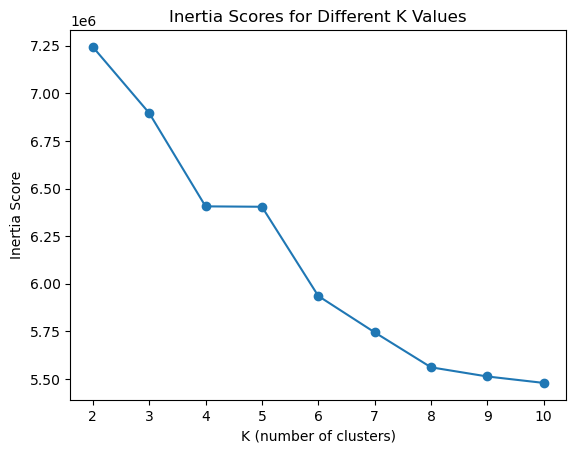

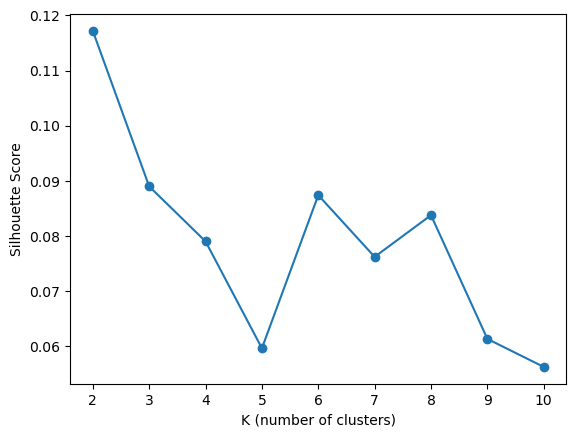

In [121]:
# visualise inertia
plt.figure()
plt.plot(k_range, k_inertia_scores, marker='o')
plt.xlabel('K (number of clusters)')
plt.ylabel('Inertia Score')
plt.title('Inertia Scores for Different K Values')
plt.xticks(k_range)
plt.show()

# visualise silhouette scores
plt.figure()
plt.plot(k_range, k_sil_scores, marker='o')
plt.xlabel('K (number of clusters)')
plt.ylabel('Silhouette Score')
plt.xticks(k_range)
plt.show()

Using the elbow method to identify values of k for which the marginal value of k is diminishing, we can identify k=4 as a suitable candidate for an optimal number of clusters. Although k=4 has a moderately low silhouette score, the difference between the score for k=4 and the highest silhouette score in our range (k=2) isn't drastic. Therefore, we can settle on k=4 as the optimal number of clusters. 

In [126]:
# create best minibatchkmeans model

# instantiate
mbkmeans = MiniBatchKMeans(n_clusters = 4, batch_size=1000, n_init='auto')

# fit and predict
mbk_y_labels = mbkmeans.fit_predict(sample)

# add labels to sample 
sample_kmeans = sample.copy()
sample_kmeans['kmeans_labels'] = mbk_y_labels

# view dataframe
display(sample_kmeans.head())

,sex,g2000,g2002,p2000,p2002,p2004,dem,hh_size,totalpopulation_estimate,percent_female,median_age,percent_65yearsandover,percent_white,percent_amindian_alaskan,percent_asian,percent_nativeandother,percent_hispanicorlatino,percent_race_other,median_income,mean_income,unemploy_16,bach_orhigher,less9thgrade,highschool,age,treatment_civic duty,treatment_hawthorne,treatment_neighbors,treatment_self,percent_under18years,percent_18to64years,kmeans_labels
120773,-0.998565,0.431905,0.482337,-0.580031,-0.799318,-0.819052,-1.067860,-1.497075,-1.047177,-1.216773,-0.332995,-1.087821,0.550907,0.119234,-0.637661,-0.483588,-0.217356,-0.279842,1.190162,0.665537,0.252452,0.046821,-0.853276,-0.417868,-0.884925,-0.353483,2.829574,-0.353394,-0.353483,1.661739,-0.427832,2
242186,-0.998565,0.431905,0.482337,-0.580031,-0.799318,-0.819052,-1.067860,-0.232413,-0.822774,0.061254,-0.016075,-0.545153,0.475874,-0.361355,-0.244770,-0.483588,-0.517506,0.398610,0.624413,0.627499,-1.120826,0.081551,-1.253695,-0.305876,0.568455,2.828991,-0.353410,-0.353394,-0.353483,1.661739,-1.100322,2
275413,-0.998565,0.431905,0.482337,1.724047,-0.799318,-0.819052,-1.067860,-1.497075,1.907729,0.572465,-1.736497,-0.054167,-0.899733,-0.018077,0.305277,0.309414,4.009759,3.984709,-0.789959,-0.636545,-0.465398,0.074605,1.778056,-0.014698,2.852339,-0.353483,-0.353410,-0.353394,-0.353483,0.283353,-0.235692,0
112518,1.001437,-2.315326,0.482337,-0.580031,1.251067,1.220924,-1.018952,-0.232413,-1.245437,-0.347715,-0.514092,-0.906931,0.500885,1.011756,-0.532890,-0.483588,-0.567531,-0.376763,-0.190546,-0.458010,1.063935,-1.210405,-0.224044,1.273206,-1.092551,-0.353483,-0.353410,-0.353394,-0.353483,1.302160,-0.267715,1
240466,-0.998565,0.431905,0.482337,-0.580031,-0.799318,1.220924,-0.578772,-0.232413,-0.183877,-0.449957,-0.219809,-1.501282,0.688468,-0.704633,-0.244770,-0.483588,-0.617556,-0.619067,2.704921,3.019275,-1.557778,2.019484,-1.310898,-1.806564,-0.331256,-0.353483,-0.353410,-0.353394,-0.353483,2.410862,-0.716042,2


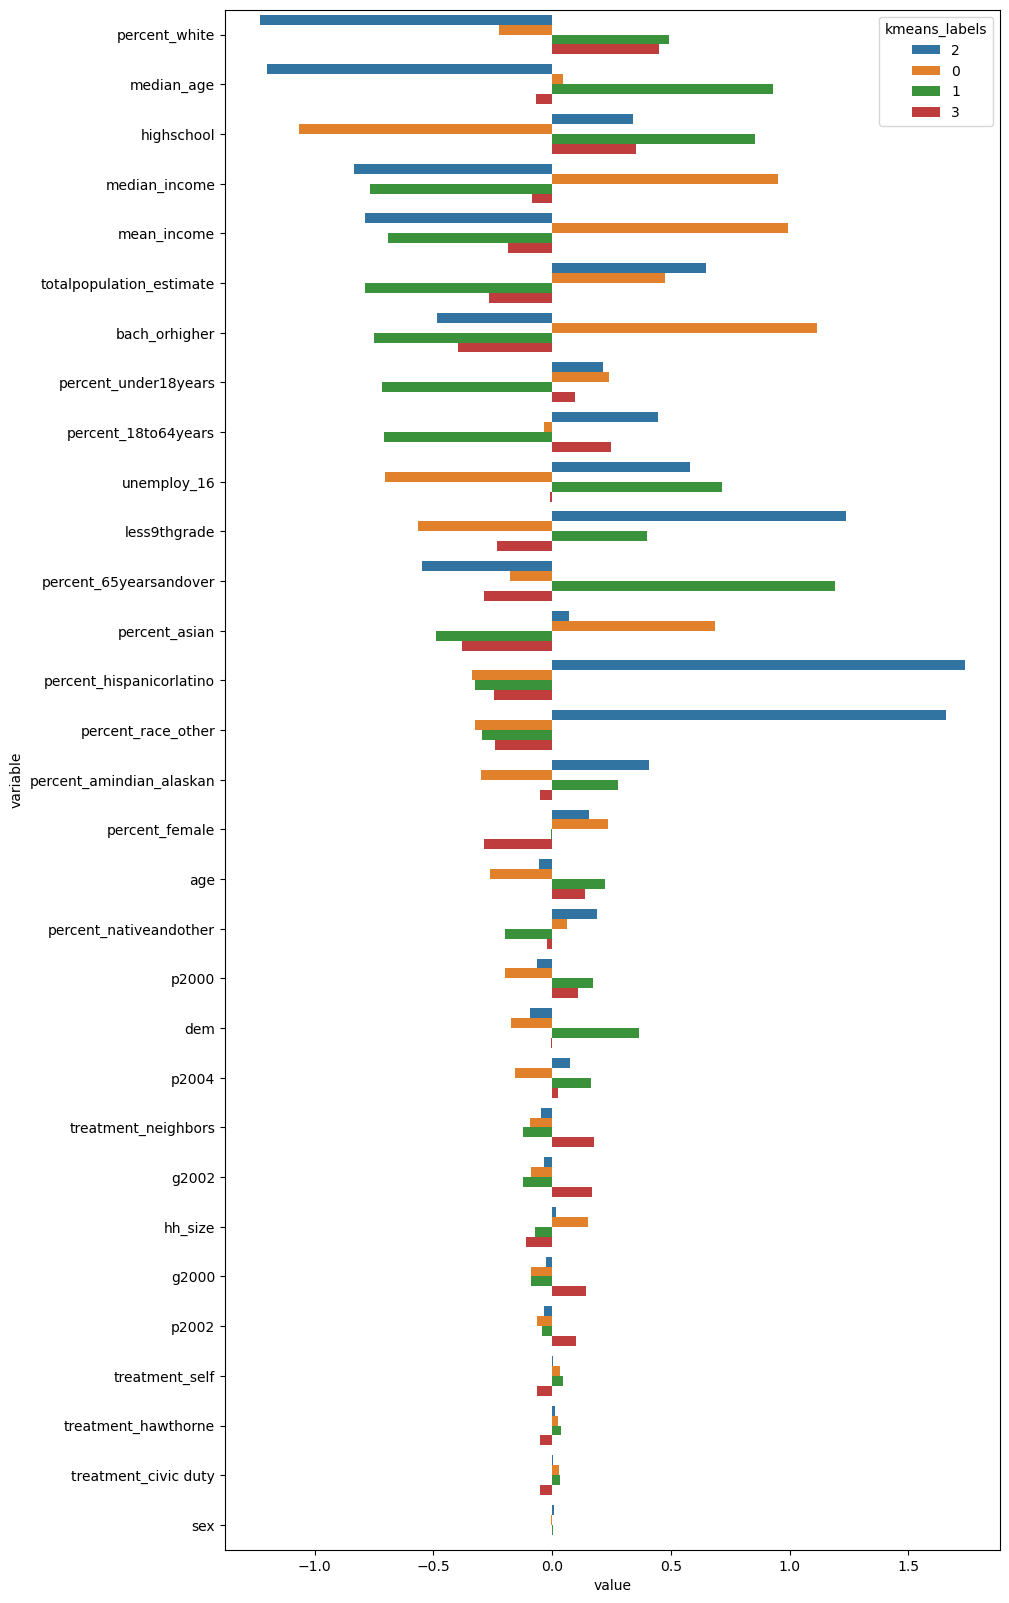

In [124]:
# group by labels
relative_means_kmeans = sample_kmeans.groupby('kmeans_labels').mean()

# melt dataframe
melted = relative_means_kmeans.reset_index().melt(id_vars = 'kmeans_labels').sort_values('value')

# convert labels to string
melted['kmeans_labels'] = melted['kmeans_labels'].astype(str)

# visualise in bar chart
plt.figure(figsize = (10,20))
sns.barplot(x='value', y='variable', hue = 'kmeans_labels', data = melted)
plt.show()

**Interpretation:** The length of the bars indicates the importance of features in distinguishing the clusters. Longer bars suggest that the feature has a larger role in defining cluster separation. Features like 'median_income' and 'mean_income' with significant variance across clusters could indicate economic differences are a strong factor in defining the clusters.
Features related to education, such as 'highschool', 'bach_orhigher', 'bachelors', 'grad', are also important, suggesting that educational attainment levels vary significantly between clusters and contribute to the population segmentation. The presence of distinct bars for different clusters suggests that there are indeed subgroups within the population with differing characteristics. The features that stand out the most (those with the longest bars) are driving the formation of these subgroups. The variety in direction (positive and negative) and length of the bars for each feature across different clusters implies heterogeneity in the population. 

**Next Steps for Clustering:**

1. Assess Cluster Stability and Validity: Before fully integrating cluster information into our modelling, we need to assess the stability and validity of the clusters. To do this, we can re-run the clustering with different initializations to ensure that the clusters are consistent. We could also use different clustering algorithms to examine the different results. This is particularly important as our inertia and silhouette scores are currently sub-optimal.

2. Cluster Labels as Features: Once cluster validity has been established, we can add the cluster labels as new features in our predictive models to see if they improve performance. These labels encapsulate the patterns discovered during clustering and can help uncover heterogenous treatment effects.

3. Segmented Modelling: If clusters seem to capture meaningful subgroups, we might develop separate predictive models for each cluster.

Due to time and space constraints, these next steps will be implemented in subsequent notebooks. 

## Modelling <a id="modelling"></a>

Having completed our EDA, we can now move on to modelling. In this section, I explore 5 types of models:
1. Logistic Regression
2. Decision Trees
3. Random Forests
4. Gradient Boosting
5. Neural Networks

For each model type, I try different variations and perform a full evaluation of each variation.

### Train-Test Split/Scaling <a id="split_scaling"></a>

Before proceeding with our modelling, we need to split the data into training and test sets. I have made two splits of the data. The first split creates a final test set (named `X_final_test` and `y_final_test`). The second split creates training and test sets designed to guide my model improvement process (named `X_train`, `X_test`, `y_train`, `y_test`). The reason for using two splits is that taking steps to improve a model based on test set performance is an implicit form of data leakage. Hence, `X_test` and `y_test` act as 'validation' sets to test for overfitting whereas performance on the `X_final_test` and `y_final_test` is the real benchmark of model performance. In addition to splitting the data, I also scale the data using a standard scaler. 

In [143]:
# create sample for computational efficiency
#sample = data.sample(frac=1, random_state=10)
sample = data.copy()

In order to avoid issues of multicollinearity, I have dropped the `treatment_control` column. 

In [144]:
# split features and target 
X = sample.drop(columns=['voted', 'treatment_control', 'votedav'])
y = sample['voted']

# perform train-test split on X and y
X_remainder, X_final_test, y_remainder, y_final_test = train_test_split(X, y, test_size = 0.1, random_state = 10, stratify=y)

# perform train-test split on X_remainder and y_remainder
X_train, X_test, y_train, y_test = train_test_split(X_remainder, y_remainder, test_size=0.2, stratify=y_remainder)

We can now move on to scaling the data and turning the scaled data back into a dataframe. 

In [145]:
# instantiate scaler
ss = StandardScaler()

# scale training data
X_train_s = ss.fit_transform(X_train)

# scale the test data
X_test_s = ss.transform(X_test)

# scale the final_test data
X_final_test_s = ss.transform(X_final_test)

In [148]:
# convert training and test data to dataframes
X_train_s = pd.DataFrame(data=X_train_s, columns=X.columns)
X_test_s = pd.DataFrame(data=X_test_s, columns=X.columns)
X_final_test_s = pd.DataFrame(data=X_final_test_s, columns=X.columns)

# display one dataframe
display(X_train_s.head())

# print dataframe shapes
print(X_train_s.shape)
print(y_train.shape)
print(X_test_s.shape)
print(y_test.shape)
print(X_final_test_s.shape)
print(y_final_test.shape)

,sex,g2000,g2002,p2000,p2002,p2004,dem,hh_size,totalpopulation_estimate,percent_female,median_age,percent_65yearsandover,percent_white,percent_black,percent_amindian_alaskan,percent_asian,percent_nativeandother,percent_other_nativeandother,percent_hispanicorlatino,percent_race_other,median_income,unemploy_16,bach_orhigher,less9thgrade,highschool,age,treatment_civic duty,treatment_hawthorne,treatment_neighbors,treatment_self,percent_under18years,percent_18to64years
0,-0.997235,0.432764,0.481954,-0.580557,1.251337,-0.819253,-1.018206,-0.234153,0.985861,-0.501867,-1.190545,-0.958214,0.613165,-0.523243,-0.499627,-0.270914,-0.482815,-0.526855,-0.492666,-0.328019,0.450727,-1.617200,0.233201,-0.053017,0.109473,-0.815845,-0.353245,-0.353592,-0.353823,-0.352558,1.721076,-0.651804
1,-0.997235,0.432764,0.481954,1.722484,1.251337,-0.819253,-0.871470,-1.498653,0.213345,0.111728,0.031057,-1.242483,0.663194,-0.473792,-0.430467,-0.270914,-0.482815,-0.526855,-0.492666,-0.473460,1.719780,0.097017,0.914034,-1.311047,-1.178740,0.500329,-0.353245,-0.353592,-0.353823,-0.352558,1.751030,-0.331969
2,1.002773,0.432764,0.481954,-0.580557,1.251337,1.220625,0.938270,-0.234153,-0.454475,-0.450734,-0.149921,-0.803158,0.237946,-0.424342,-0.568787,-0.061443,1.892432,0.067040,-0.267632,0.059824,0.853778,-0.276994,0.559723,-1.025131,-0.853886,-0.538755,-0.353245,-0.353592,-0.353823,-0.352558,0.103585,0.883401
3,1.002773,0.432764,0.481954,-0.580557,-0.799145,1.220625,1.769772,-1.498653,1.745990,-0.859798,-1.258411,-0.777315,-2.200978,3.267948,0.952732,-0.480384,0.308934,-0.229907,0.757521,0.932470,-1.606091,3.369615,-1.468881,1.490928,1.408889,2.647771,-0.353245,-0.353592,-0.353823,2.836413,0.343214,0.595550
4,1.002773,0.432764,0.481954,-0.580557,-0.799145,-0.819253,-1.067118,-0.234153,-0.054390,1.134386,0.393013,0.127177,0.200424,0.020711,-0.430467,-0.035259,-0.482815,-0.526855,-0.492666,-0.473460,2.212600,-1.804206,3.046846,-1.425413,-2.578973,-0.815845,-0.353245,-0.353592,-0.353823,-0.352558,0.043678,-0.204036


(247740, 32)
(247740,)
(61935, 32)
(61935,)
(34409, 32)
(34409,)


At the end of our splitting and scaling process, we have 6 separate datasets that we can use for modelling. We can now move to our logistic regression modelling. 

### Logistic Regression <a id="logistic_regresion"></a>

For each logistic regression model, I perform the following process: 
1. Choose features
2. Instantiate and fit the model
3. Extract and display coefficients
4. Evaluate the model using accuracy, a confusion matrix, precision, recall, f1 score and roc/auc
5. Discuss the model output

#### Logistic Regression Model 1: Baseline Model <a id="lr1"></a>

This model includes just the treatments. 

,0,1,2,3
Feature,treatment_neighbors,treatment_self,treatment_hawthorne,treatment_civic duty
Coefficients,0.115991,0.070969,0.038037,0.026881
Absolute Coef,0.115991,0.070969,0.038037,0.026881
Odds_Ratio,1.122986,1.073548,1.038769,1.027245


Training Score: 0.6841002664083313
Test Score: 0.6841043028981997


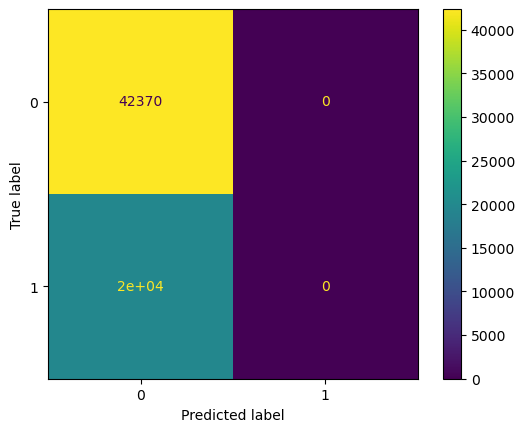

Confusion Matrix (DataFrame):


,Predicted Negative,Predicted Positive
True Negative,42370,0
True Positive,19565,0



Classification Report:
              precision    recall  f1-score   support

           0       0.68      1.00      0.81     42370
           1       0.00      0.00      0.00     19565

    accuracy                           0.68     61935
   macro avg       0.34      0.50      0.41     61935
weighted avg       0.47      0.68      0.56     61935



/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


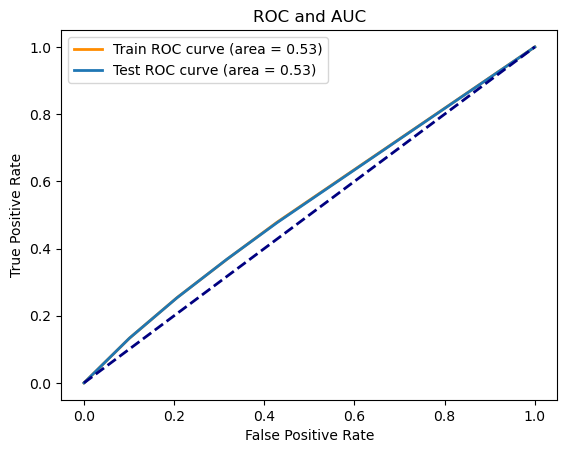

Test AUC score: 0.5307148252398566
Train AUC score: 0.5312054560020598


In [127]:
# choose features and target for training set

X_train_lr1 = X_train_s[['treatment_civic duty', 'treatment_hawthorne', 'treatment_neighbors', 'treatment_self']]
X_test_lr1 = X_test_s[['treatment_civic duty', 'treatment_hawthorne', 'treatment_neighbors', 'treatment_self']]

# instantiate and fit model 

lr1 = LogisticRegression()
lr1.fit(X_train_lr1, y_train)

# print coefficients 
display(u.get_model_coefficients(X_train_lr1, lr1))

# model evaluation 
u.evaluate_model(lr1, X_train_lr1, y_train, X_test_lr1, y_test)

**Model 1 Discussion**

**Important Features:** Each of these coefficients can be interpreted as the extent to which each treatment impacts the probability of an individual voting, compared to the control group. Neighbors seems to be the most impactful feature, followed by self, hawthorne and civic duty, in this order. This coheres with the order of treatments as ascending in the level of social pressure exerted with neighbours exerting the most pressure and civic duty exerting the least. 

**Model Performance:** The model demonstrated a precision of 0.68 for class 0, indicating that when it predicts an individual did not vote, it is correct 68% of the time. However, for class 1 (those who voted), the precision is 0.00, indicating it never correctly predicts positive cases. The recall for class 0 is 1.00, showing it correctly identifies all negative cases, but for class 1, the recall is 0.00, indicating it fails to identify any true positive cases. Accuracy stands at 0.68, which is misleading since the model performs very poorly on the positive class. Overall, this model seems heavily biased towards predicting the majority class. This means that the lack of any predictive power for the positive class suggests that the treatment features alone do not capture enough information to distinguish between those who voted and those who did not.

#### Logistic Regression Model 2: Treatments + Essential Control Variables <a id="lr2"></a>

This model aims to improve on the lack of predictive power in Model 1 for predicting class 1 (voters) by adding control variables for previous voting behaviour. 

,0,1,2,3,4,5,6,7,8
Feature,p2004,p2002,g2002,p2000,treatment_neighbors,treatment_self,treatment_hawthorne,treatment_civic duty,g2000
Coefficients,0.372099,0.30741,0.235795,0.200646,0.124284,0.075089,0.039204,0.028077,0.013054
Absolute Coef,0.372099,0.30741,0.235795,0.200646,0.124284,0.075089,0.039204,0.028077,0.013054
Odds_Ratio,1.450777,1.359898,1.265915,1.222192,1.132338,1.07798,1.039983,1.028475,1.013139


Training Score: 0.6977960765318479
Test Score: 0.6985549366271091


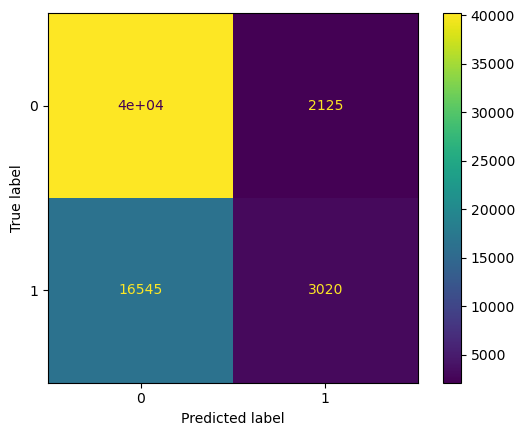

Confusion Matrix (DataFrame):


,Predicted Negative,Predicted Positive
True Negative,40245,2125
True Positive,16545,3020



Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.95      0.81     42370
           1       0.59      0.15      0.24     19565

    accuracy                           0.70     61935
   macro avg       0.65      0.55      0.53     61935
weighted avg       0.67      0.70      0.63     61935



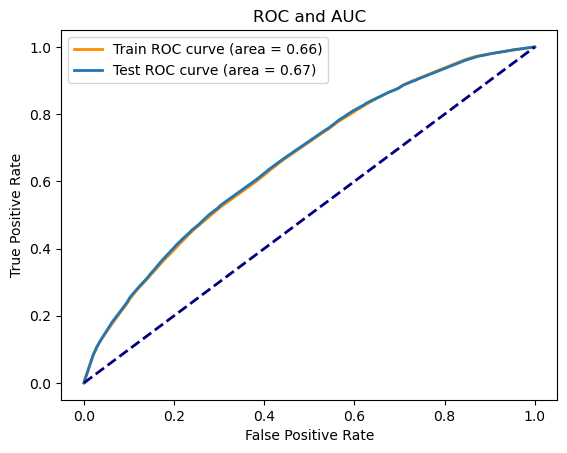

Test AUC score: 0.6661262836049187
Train AUC score: 0.6639650040897405


In [128]:
# choose features and target
X_train_lr2 = X_train_s[['treatment_civic duty', 'treatment_hawthorne', 'treatment_neighbors', 'treatment_self', 'g2000', 'g2002', 'p2000', 'p2002', 'p2004']]
X_test_lr2 = X_test_s[['treatment_civic duty', 'treatment_hawthorne', 'treatment_neighbors', 'treatment_self', 'g2000', 'g2002', 'p2000', 'p2002', 'p2004']]

# instantiate and fit model 
lr2 = LogisticRegression()
lr2.fit(X_train_lr2, y_train)

# print coefficients 
display(u.get_model_coefficients(X_train_lr2, lr2))

# model evaluation 
u.evaluate_model(lr2, X_train_lr2, y_train, X_test_lr2, y_test)

**Model 2 Discussion**

**Important Features:** Unsurprisingly, past voting behaviour seems to be the most important predictor of current voting behaviour. However, the inclusion of the control variables has only marginally changed the coefficients for the treatment variables. The same order (neighbors > self > hawthorne > civic duty) remains. 

**Model Performance:** Precision and recall improved for both classes compared to the baseline model, with a precision of 0.71 for class 0 and 0.59 for class 1. The recall is 0.95 for class 0 but remains low at 0.15 for class 1, indicating an improvement in identifying true positives but still missing many. The overall accuracy increased slightly to 0.70, and the F1-score for class 1 increased to 0.24, suggesting a better balance between precision and recall for predicting those who voted. This is presumably because the inclusion of essential control variables (election years) likely provided additional context that helped the model differentiate between the classes better than treatment features alone. However, despite the improvements, the model's performance on the positive class is still limited, potentially due to class imbalance and the possibility that the selected features do not fully capture the factors influencing voting behavior.

#### Logistic Regression Model 3: All Variables <a id="lr3"></a>

To improve predictive power and for the sake of experimentation, model 3 improves on model 2 by adding all of feature columns into our analysis. 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
Feature,p2004,p2002,g2002,age,p2000,percent_race_other,percent_hispanicorlatino,median_income,highschool,treatment_neighbors,percent_under18years,percent_black,treatment_self,dem,bach_orhigher,percent_65yearsandover,totalpopulation_estimate,unemploy_16,percent_asian,treatment_hawthorne,g2000,percent_amindian_alaskan,treatment_civic duty,percent_white,percent_other_nativeandother,percent_18to64years,median_age,percent_nativeandother,hh_size,less9thgrade,percent_female,sex
Coefficients,0.389634,0.309055,0.202683,0.190824,0.187018,-0.182965,0.175942,0.162783,0.162181,0.127409,-0.088001,0.082601,0.077683,-0.069757,-0.066161,0.064834,0.057184,-0.053513,0.047517,0.041967,-0.038091,-0.038072,0.033003,0.029937,-0.014651,0.013724,-0.013491,0.01072,0.009981,-0.008296,0.007943,-0.005954
Absolute Coef,0.389634,0.309055,0.202683,0.190824,0.187018,0.182965,0.175942,0.162783,0.162181,0.127409,0.088001,0.082601,0.077683,0.069757,0.066161,0.064834,0.057184,0.053513,0.047517,0.041967,0.038091,0.038072,0.033003,0.029937,0.014651,0.013724,0.013491,0.01072,0.009981,0.008296,0.007943,0.005954
Odds_Ratio,1.47644,1.362137,1.224684,1.210247,1.205649,0.832797,1.192369,1.176781,1.176073,1.135881,0.91576,1.086108,1.08078,0.932621,0.93598,1.066982,1.058851,0.947894,1.048664,1.04286,0.962625,0.962643,1.033553,1.03039,0.985456,1.013819,0.9866,1.010777,1.010031,0.991738,1.007975,0.994063


Training Score: 0.7016630338257851
Test Score: 0.6989585856139501


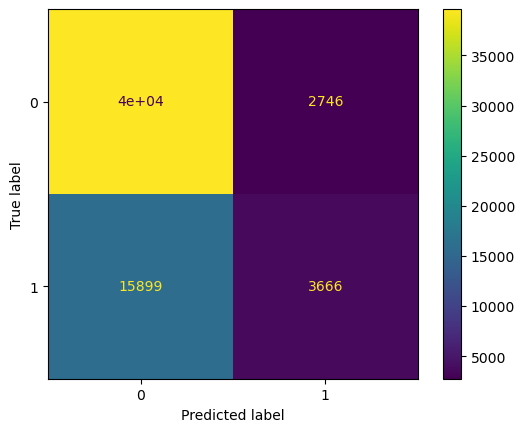

Confusion Matrix (DataFrame):


,Predicted Negative,Predicted Positive
True Negative,39624,2746
True Positive,15899,3666



Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.94      0.81     42370
           1       0.57      0.19      0.28     19565

    accuracy                           0.70     61935
   macro avg       0.64      0.56      0.55     61935
weighted avg       0.67      0.70      0.64     61935



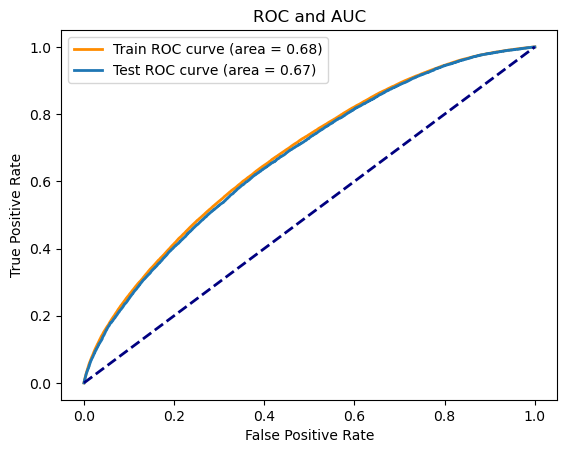

Test AUC score: 0.6714777234445604
Train AUC score: 0.678350967687144


In [149]:
# choose features and target variables
X_train_lr3 = X_train_s
X_test_lr3 = X_test_s

# instantiate and fit model
lr3 = LogisticRegression()
lr3.fit(X_train_lr3, y_train)

# interpret model by printing coefficients
display(u.get_model_coefficients(X_train_lr3, lr3))

# evaluate model 
u.evaluate_model(lr3, X_train_lr3, y_train, X_test_lr3, y_test)

**Model 3 Discussion**

**Important Features:** There are some interesting additional influencers of voting behaviour in this model compared to the previous two. Firstly, demographic variables (`percent_race_other`, `percent_hispanicorlatino`, `percent_white`, `percent_65yearsandover`). Coefficients associated with racial demographics and age suggest these factors significantly influence voting patterns. For instance, 'percent_race_other' has a negative coefficient, implying that as the percentage of the population categorized as 'other' races increases, the likelihood of voting decreases, perhaps indicating issues with representation or engagement. Secondly, socioeconomic factors (`median_income`, `highschool`) seem to influence voting behaviour. This may give us some insight into the existence of subgroups that are defined by these characteristics. However, the coefficients from a logistic regression are too coarse-grained to fully identify these groups.

**Model Performance:** Precision and recall for class 0 remained similar to Model 2, with a slight improvement in precision for class 1. The recall for class 1 improved to 0.19, indicating the model is getting better at identifying voters but still has a high rate of false negatives. Overall accuracy is ~0.70, matching Model 2, with a slight improvement in the macro average and weighted average F1-scores, reflecting a more balanced performance across classes. By using all available variables, the model seems to capture more complex relationships within the data, leading to incremental improvements in identifying the positive class.
The remaining performance challenges could be due to noise introduced by less informative variables or inherent limitations in the dataset that prevent a clearer separation between the classes.

#### Logistic Regression Model 4 & 5: Eliminating Problematic Features and SelectKBest <a id="lr4/5"></a>

These models aim to improve on models 1-3 by taking a more rigorous approach to feature selection by eliminating highly correlated features and using SelectKBest to choose features. 

**Removing Collinear Features (Model 4)**

Here, we look for pairs of variables that have an absolute correlation coefficient of over 0.7 and drop them from our training set. The hope is that this will lead to better model performance as it mitigates any problems associated with multicollinearity. 

In [152]:
# find highly correlated features := |p| > 0.7
u.find_correlated_pairs(X_train_s.corr(), 0.7)

[('median_age', 'percent_65yearsandover', 0.7425385872844806),
 ('percent_white', 'percent_black', -0.8577406641186258),
 ('percent_hispanicorlatino', 'percent_race_other', 0.9111643173034505),
 ('median_income', 'bach_orhigher', 0.7719334383908083),
 ('median_income', 'highschool', -0.7265392849337875),
 ('bach_orhigher', 'highschool', -0.9519798639007763)]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
Feature,p2004,p2002,bach_orhigher,g2002,age,p2000,median_income,percent_under18years,treatment_neighbors,treatment_self,dem,percent_black,unemploy_16,totalpopulation_estimate,percent_race_other,percent_18to64years,treatment_hawthorne,percent_amindian_alaskan,g2000,percent_asian,treatment_civic duty,median_age,hh_size,percent_female,less9thgrade,percent_other_nativeandother,percent_nativeandother,sex
Coefficients,0.389427,0.309872,-0.209423,0.202822,0.190978,0.18617,0.155546,-0.151622,0.127331,0.077683,-0.068861,0.062301,-0.05193,0.048375,-0.045185,-0.043559,0.041965,-0.041589,-0.037649,0.035008,0.032795,-0.03249,0.010179,0.009551,0.008605,-0.007771,0.006221,-0.005966
Absolute Coef,0.389427,0.309872,0.209423,0.202822,0.190978,0.18617,0.155546,0.151622,0.127331,0.077683,0.068861,0.062301,0.05193,0.048375,0.045185,0.043559,0.041965,0.041589,0.037649,0.035008,0.032795,0.03249,0.010179,0.009551,0.008605,0.007771,0.006221,0.005966
Odds_Ratio,1.476134,1.363251,0.811052,1.224855,1.210433,1.204628,1.168296,0.859313,1.135793,1.08078,0.933457,1.064283,0.949395,1.049564,0.95582,0.957376,1.042858,0.959264,0.963051,1.035628,1.033339,0.968032,1.010231,1.009597,1.008642,0.99226,1.006241,0.994051


Training Score: 0.7014127714539437
Test Score: 0.6985549366271091


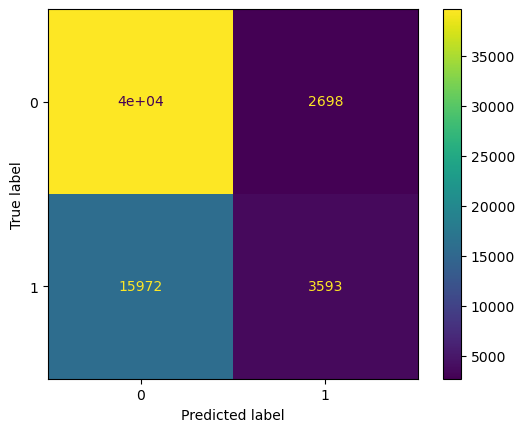

Confusion Matrix (DataFrame):


,Predicted Negative,Predicted Positive
True Negative,39672,2698
True Positive,15972,3593



Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.94      0.81     42370
           1       0.57      0.18      0.28     19565

    accuracy                           0.70     61935
   macro avg       0.64      0.56      0.54     61935
weighted avg       0.67      0.70      0.64     61935



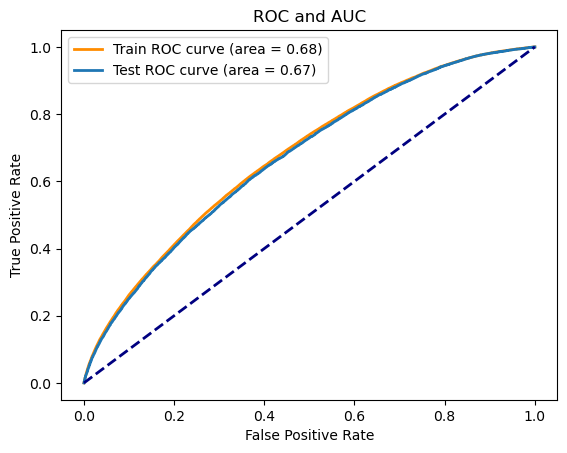

Test AUC score: 0.6708112003699053
Train AUC score: 0.6772070907190678


In [153]:
# drop columns
X_train_lr4 = X_train_s.drop(columns=['percent_65yearsandover', 'percent_hispanicorlatino', 'highschool', 'percent_white'])
X_test_lr4 = X_test_s.drop(columns=['percent_65yearsandover', 'percent_hispanicorlatino', 'highschool', 'percent_white'])

# instantiate and fit model
lr4 = LogisticRegression()
lr4.fit(X_train_lr4, y_train)

# get coefficients
display(u.get_model_coefficients(X_train_lr4, lr4))

# print model evaluation
u.evaluate_model(lr4, X_train_lr4, y_train, X_test_lr4, y_test)

**SelectKBest (Model 5)**

In [154]:
from sklearn.feature_selection import SelectKBest, f_classif

# instantiate and fit
skb = SelectKBest(k=16)
skb.fit(X_train_s, y_train)

# get feature names
skb.get_feature_names_out()

array(['g2000', 'g2002', 'p2000', 'p2002', 'p2004', 'hh_size',
       'median_age', 'percent_65yearsandover', 'median_income',
       'unemploy_16', 'bach_orhigher', 'highschool', 'age',
       'treatment_neighbors', 'treatment_self', 'percent_under18years'],
      dtype=object)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Feature,p2004,p2002,g2002,p2000,age,median_income,treatment_neighbors,percent_under18years,bach_orhigher,median_age,treatment_self,percent_65yearsandover,unemploy_16,g2000,highschool,hh_size
Coefficients,0.379926,0.305173,0.208849,0.18625,0.18304,0.146753,0.11635,-0.109991,-0.106712,-0.076718,0.066657,0.064127,-0.033435,-0.028349,0.019337,0.017078
Absolute Coef,0.379926,0.305173,0.208849,0.18625,0.18304,0.146753,0.11635,0.109991,0.106712,0.076718,0.066657,0.064127,0.033435,0.028349,0.019337,0.017078
Odds_Ratio,1.462176,1.35686,1.232259,1.204724,1.200862,1.158068,1.123389,0.895842,0.898785,0.926151,1.068929,1.066228,0.967118,0.972049,1.019525,1.017225


Training Score: 0.7003067732299992
Test Score: 0.6977637846129007


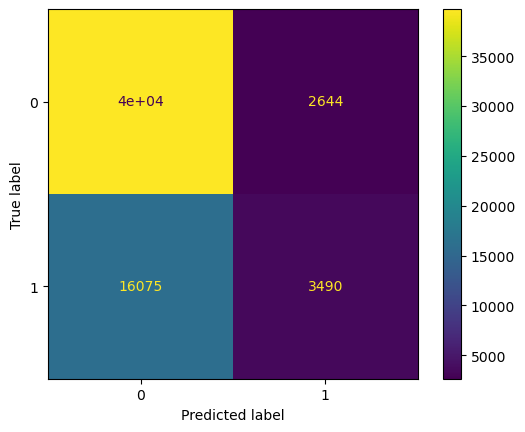

Confusion Matrix (DataFrame):


,Predicted Negative,Predicted Positive
True Negative,39726,2644
True Positive,16075,3490



Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.94      0.81     42370
           1       0.57      0.18      0.27     19565

    accuracy                           0.70     61935
   macro avg       0.64      0.56      0.54     61935
weighted avg       0.67      0.70      0.64     61935



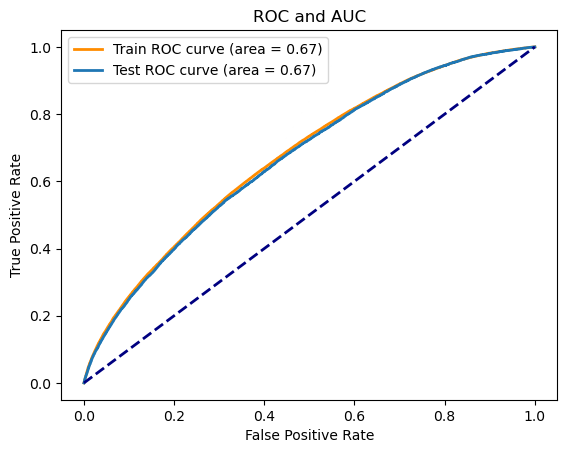

Test AUC score: 0.668470427816334
Train AUC score: 0.6739851773752972


In [155]:
# transform train set and test set
X_train_lr5 = pd.DataFrame(data=skb.transform(X_train_s), columns=skb.get_feature_names_out())
X_test_lr5 = pd.DataFrame(data=skb.transform(X_test_s), columns=skb.get_feature_names_out())

# run logistic regression model with k-best features
lr5 = LogisticRegression()
lr5.fit(X_train_lr5, y_train)

# print coefficients 
display(u.get_model_coefficients(X_train_lr5, lr5))

# model evaluation 
u.evaluate_model(lr5, X_train_lr5, y_train, X_test_lr5, y_test)

**Model 4 & 5 Discussion**

Both Model 4 and Model 5 yield similar performance metrics, suggesting that the most informative features for the outcome were present in both models. The fact that removing collinear features and selecting the top features statistically did not significantly change the performance metrics indicates that the key predictive information resides in a core set of features that are common to both models.

**Model Performance:** Precision and Recall: Both models struggle with class 1, which indicates that they may not have included enough predictive features for this class or that the models need a more balanced dataset to learn from.
- Accuracy: The accuracy metric is consistent across both models, which may not be the best metric to focus on given the class imbalance.
- F1-Score: The similarity in F1-scores suggests that both feature selection methods ended up with features that have comparable predictive capabilities.

#### Logistic Regression Model 6: SMOTE <a id="lr6"></a>

In order to deal with the persisting problem of low recall on the positive class (voters), the next model uses SMOTE to artificially create new datapoints so that we can address the class imbalance. 

In [167]:
# implement SMOTE
from imblearn.over_sampling import SMOTE
X_train_smote, y_train_smote = SMOTE(random_state=10).fit_resample(X_train, y_train)

# check new class balance
print(y_train_smote.value_counts(normalize=True))

# scaling SMOTE-d data
ss_smote = StandardScaler()
X_train_lr6 = pd.DataFrame(data=ss_smote.fit_transform(X_train_smote), columns=X_train_smote.columns)
X_test_lr6 = pd.DataFrame(data=ss_smote.transform(X_test), columns=X_test.columns)

voted
0    0.5
1    0.5
Name: proportion, dtype: float64


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
Feature,sex,treatment_civic duty,treatment_hawthorne,hh_size,percent_race_other,treatment_self,age,percent_hispanicorlatino,p2004,highschool,treatment_neighbors,median_income,g2002,g2000,p2002,percent_under18years,percent_65yearsandover,bach_orhigher,dem,percent_black,unemploy_16,percent_amindian_alaskan,totalpopulation_estimate,median_age,percent_asian,percent_other_nativeandother,percent_nativeandother,percent_female,percent_18to64years,less9thgrade,percent_white,p2000
Coefficients,-0.264221,-0.233883,-0.224323,-0.217942,-0.197629,-0.191547,0.189699,0.17588,0.162666,0.152896,-0.146948,0.136493,0.1296,-0.09335,0.091754,-0.087896,0.069091,-0.067344,-0.065118,0.064518,-0.052752,-0.045566,0.036604,-0.022253,0.020428,-0.014833,0.011287,0.010671,0.008008,0.004037,-0.002524,-0.000436
Absolute Coef,0.264221,0.233883,0.224323,0.217942,0.197629,0.191547,0.189699,0.17588,0.162666,0.152896,0.146948,0.136493,0.1296,0.09335,0.091754,0.087896,0.069091,0.067344,0.065118,0.064518,0.052752,0.045566,0.036604,0.022253,0.020428,0.014833,0.011287,0.010671,0.008008,0.004037,0.002524,0.000436
Odds_Ratio,0.767804,0.791455,0.799057,0.804172,0.820675,0.825681,1.208886,1.192295,1.176644,1.165204,0.863339,1.146247,1.138373,0.910875,1.096095,0.915856,1.071533,0.934873,0.936957,1.066645,0.948615,0.955457,1.037282,0.977993,1.020638,0.985277,1.011351,1.010729,1.00804,1.004045,0.997479,0.999564


Training Score: 0.6265171496173567
Test Score: 0.5737466698958585


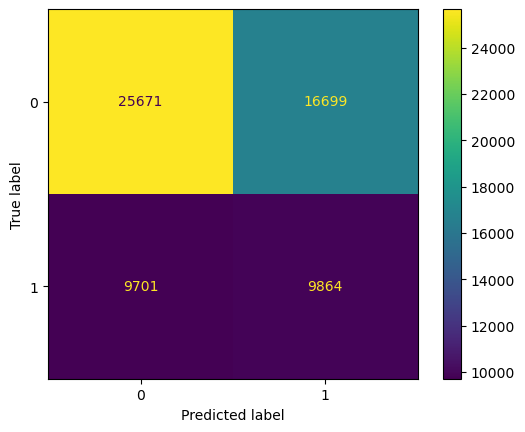

Confusion Matrix (DataFrame):


,Predicted Negative,Predicted Positive
True Negative,25671,16699
True Positive,9701,9864



Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.61      0.66     42370
           1       0.37      0.50      0.43     19565

    accuracy                           0.57     61935
   macro avg       0.55      0.56      0.54     61935
weighted avg       0.61      0.57      0.59     61935



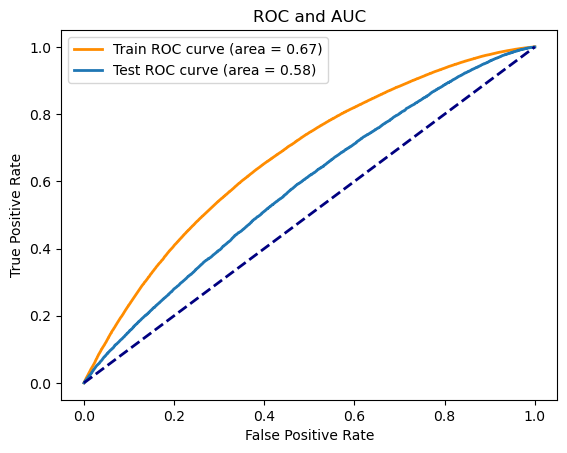

Test AUC score: 0.5829003525523662
Train AUC score: 0.672097068060066


In [168]:
# instantiate and fit model
lr6 = LogisticRegression()
lr6.fit(X_train_lr6, y_train_smote)

# get coefficients
display(u.get_model_coefficients(X_train_lr6, lr6))

# print model evaluation
u.evaluate_model(lr6, X_train_lr6, y_train_smote, X_test_lr6, y_test)

**Model 6 Discussion**

**Important Features:** Many features that were previously not very predictive of voting behaviour are now important. Examples include `sex` and household size. Furthermore, the absolute coefficients for all treatment variables except `civic_duty` have also increased. However, they now seem to *decrease* the probability of voting. 

**Model Performance:** After addressing class imbalance with SMOTE, the precision for class 0 (did not vote) is 0.73 with a recall of 0.60. For class 1 (voted), the precision is 0.37 with a recall of 0.51. The accuracy dropped to 0.57, but there is a notable improvement in the recall for class 1. The macro-average F1-score across both classes stands at 0.54, which is an improvement from the baseline models for class 1, indicating a better balance between precision and recall. SMOTE helps to mitigate class imbalance by creating synthetic samples for the minority class. This leads to a more balanced dataset, which allows the logistic regression model to learn better representations for both classes. Unfortunately, the improved recall for class 1 at the expense of reduced precision for class 0 suggests that the model is now identifying more true positives of the minority class but also misclassifying more majority class samples as the minority class (false positives). The decrease in overall accuracy can be attributed to the model no longer predominantly predicting the majority class.

#### Logistic Regression Model 7: GridSearchCV <a id="lr7"></a>

This model aims to improve on the previous models by using hyperparameter tuning with GridSearchCV. The GridSearchCV process aimed to find the best regularization strength (C) and penalty (l1 or l2) for the logistic regression model.

In [156]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline

# build pipeline
logreg_estimators = [('scaling', StandardScaler()),
                     ('logreg_model', LogisticRegression(solver='liblinear', random_state=10))]

logreg_pipe = Pipeline(logreg_estimators)

# define parameter grid 

logreg_params = {
    'logreg_model__penalty': ['l1', 'l2'],
    'logreg_model__C':[0.1, 0.5, 1, 2, 5, 10]
}

In [157]:
# run gridsearchCV
logreg_gridsearch = GridSearchCV(logreg_pipe, param_grid = logreg_params)
logreg_gridsearch.fit(X_train, y_train)

# get best estimator 
logreg_gridsearch.best_estimator_

Pipeline(steps=[('scaling', StandardScaler()),
                ('logreg_model',
                 LogisticRegression(C=2, penalty='l1', random_state=10,
                                    solver='liblinear'))])

0.7016509243561798
0.699007023492371


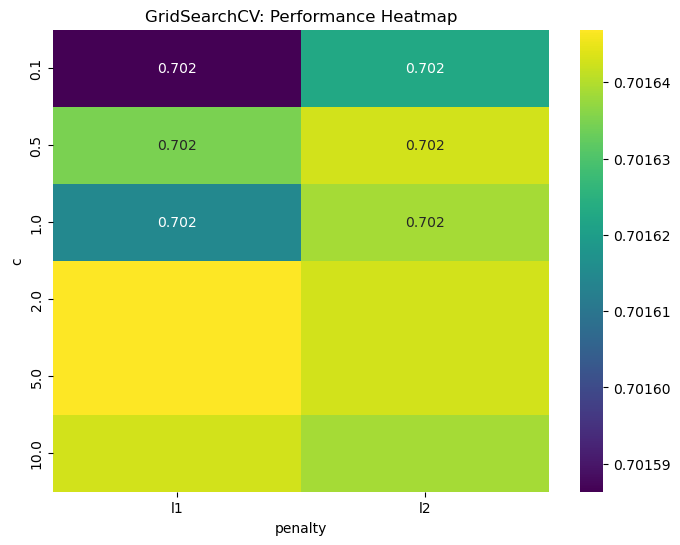

In [158]:
# print test and training scores
print(logreg_gridsearch.score(X_train, y_train))
print(logreg_gridsearch.score(X_test, y_test))

# plot out heatmap
results_grid = pd.DataFrame(logreg_gridsearch.cv_results_)
scores_matrix = results_grid.pivot(columns='param_logreg_model__penalty', index='param_logreg_model__C', values='mean_test_score')
plt.figure(figsize=(8, 6))
sns.heatmap(scores_matrix, annot=True, fmt=".3f", cmap='viridis')
plt.title('GridSearchCV: Performance Heatmap')
plt.xlabel('penalty')
plt.ylabel('c')
plt.show()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
Feature,p2004,p2002,g2002,age,p2000,percent_race_other,percent_hispanicorlatino,highschool,median_income,treatment_neighbors,percent_under18years,percent_black,treatment_self,dem,bach_orhigher,totalpopulation_estimate,unemploy_16,percent_65yearsandover,percent_asian,treatment_hawthorne,percent_amindian_alaskan,g2000,treatment_civic duty,percent_white,percent_other_nativeandother,median_age,percent_nativeandother,hh_size,less9thgrade,percent_female,sex,percent_18to64years
Coefficients,0.389623,0.309059,0.202665,0.190816,0.187003,-0.183602,0.17582,0.16249,0.162288,0.127398,-0.101696,0.080206,0.077672,-0.069748,-0.0655,0.05726,-0.053492,0.048502,0.045921,0.041955,-0.038493,-0.038074,0.032991,0.026576,-0.014645,-0.013133,0.010685,0.009969,-0.008246,0.007947,-0.005945,0.000801
Absolute Coef,0.389623,0.309059,0.202665,0.190816,0.187003,0.183602,0.17582,0.16249,0.162288,0.127398,0.101696,0.080206,0.077672,0.069748,0.0655,0.05726,0.053492,0.048502,0.045921,0.041955,0.038493,0.038074,0.032991,0.026576,0.014645,0.013133,0.010685,0.009969,0.008246,0.007947,0.005945,0.000801
Odds_Ratio,1.476424,1.362142,1.224662,1.210237,1.205631,0.832267,1.192223,1.176437,1.176199,1.135869,0.903304,1.08351,1.080768,0.932629,0.936599,1.058931,0.947914,1.049698,1.046991,1.042847,0.962239,0.962642,1.033541,1.026933,0.985462,0.986953,1.010742,1.010019,0.991788,1.007979,0.994073,1.000802


Training Score: 0.7016509243561798
Test Score: 0.699007023492371


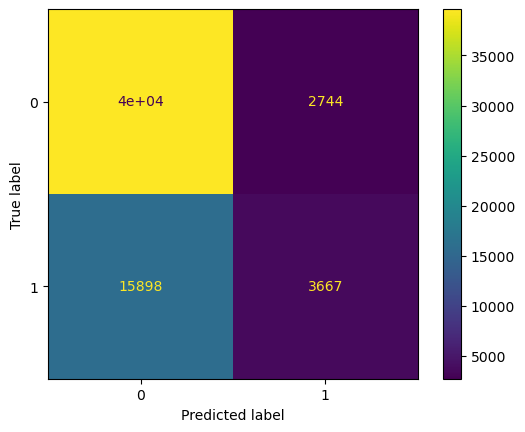

Confusion Matrix (DataFrame):


,Predicted Negative,Predicted Positive
True Negative,39626,2744
True Positive,15898,3667



Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.94      0.81     42370
           1       0.57      0.19      0.28     19565

    accuracy                           0.70     61935
   macro avg       0.64      0.56      0.55     61935
weighted avg       0.67      0.70      0.64     61935



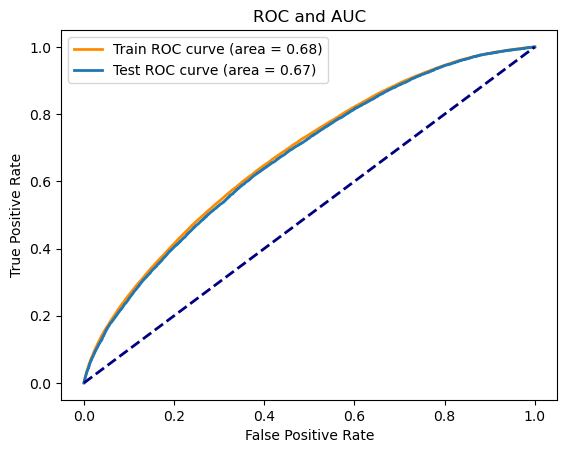

Test AUC score: 0.6714757052751246
Train AUC score: 0.6783508345407485


In [165]:
# define train and test set
X_train_lr7 = X_train_s
X_test_lr7 = X_test_s

# run best model 
lr7 = LogisticRegression(C=2, penalty='l1', random_state=10, solver='liblinear')
lr7.fit(X_train_lr7, y_train)

# get coefficients
display(u.get_model_coefficients(X_train_lr7, lr7))

# evaluate model
u.evaluate_model(lr7, X_train_lr7, y_train, X_test_lr7, y_test)

**Model 7 Discussion**

**Model Performance:** The best model from GridSearchCV achieved a precision of 0.71 for class 0 and 0.57 for class 1, with respective recalls of 0.94 and 0.19. The accuracy of the optimized model remained at 0.70, consistent with some previous models. The macro-average and weighted average F1-scores are 0.55 and 0.64, respectively, showing that the model's ability to balance precision and recall is comparable to earlier models without SMOTE. The model performance did not significantly differ from the non-SMOTE models, suggesting that hyperparameter tuning alone, without addressing the class imbalance, may not yield improvements in identifying the minority class.

#### Logistic Regression Model Summaries <a id="lr_summary"></a>

In [169]:
# create lists of models, train sets, test sets, y_trains, y_tests
logreg_models = [lr1, lr2, lr3, lr4, lr5, lr6, lr7]
logreg_names = ['Baseline', 'Controls Included', 'All Variables', 'No Collinear Features', 'SelectKBest', 'SMOTE', 'GridSearchCV']
logreg_train_sets = [X_train_lr1, X_train_lr2, X_train_lr3, X_train_lr4, X_train_lr5, X_train_lr6, X_train_lr7]
logreg_test_sets = [X_test_lr1, X_test_lr2, X_test_lr3, X_test_lr4, X_test_lr5, X_test_lr6, X_test_lr7]
logreg_y_train = [y_train, y_train, y_train, y_train, y_train, y_train_smote, y_train]
logreg_y_test = [y_test, y_test, y_test, y_test, y_test, y_test, y_test]

u.summarize_lr_models(logreg_names, logreg_models, logreg_train_sets, logreg_test_sets, logreg_y_train, logreg_y_test)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Model Name,Number of Features,Feature Names,Training Accuracy,Test Accuracy,Precision,Recall,F1 Score,AUC Score
0,Baseline,4,"[treatment_civic duty, treatment_hawthorne, tr...",0.684100,0.684104,0.000000,0.000000,0.000000,0.505665
1,Controls Included,9,"[treatment_civic duty, treatment_hawthorne, tr...",0.653120,0.654767,0.323421,0.085050,0.134682,0.501221
2,All Variables,32,"[sex, g2000, g2002, p2000, p2002, p2004, dem, ...",0.701663,0.698959,0.571740,0.187375,0.282250,0.671478
3,No Collinear Features,28,"[sex, g2000, g2002, p2000, p2002, p2004, dem, ...",0.701413,0.698555,0.571133,0.183644,0.277924,0.670811
4,SelectKBest,16,"[g2000, g2002, p2000, p2002, p2004, hh_size, m...",0.700307,0.697764,0.568960,0.178380,0.271606,0.668470
5,SMOTE,32,"[sex, g2000, g2002, p2000, p2002, p2004, dem, ...",0.626517,0.573747,0.371344,0.504166,0.427680,0.582900
6,GridSearchCV,32,"[sex, g2000, g2002, p2000, p2002, p2004, dem, ...",0.701651,0.699007,0.571986,0.187427,0.282338,0.671476


**Overall Model Summary**

Most of our non-SMOTE models perform comparably. Given our baseline accuracy of ~68%, these models have not made a large improvement on our ability to distinguish between voters and non-voters based on the characteristics in our dataset. When choosing our best model, we need to decide whether we care more about balancing the identification of both classes or just the minority class. If the goal is to balance the identification of both classes and the model’s ability to discriminate between those who voted and those who did not, the All Variables Model and GridSearchCV Model show the best performance with high accuracy, precision, and AUC scores. If the primary concern is to maximize the identification of the minority class (those who voted), which could be important in applications like targeted interventions, the SMOTE Model has the highest recall, despite a decrease in overall accuracy and precision.

**Next Steps:**
- More feature engineering designed at capturing interaction effects between features in our dataset.
- Hyperparameter tuning on our SMOTE model using recall/f1 score as the evaluation metric to optimise. 

### Decision Tree <a id="decision_tree"></a>

We now move to our second modelling approach - Decision Trees. I build one decision tree model using the following process: 
1. Define features and target
2. Use RandomizedSearchCV to narrow down a range for optimal hyperparameters
3. Use GridSearchCV to do more exhaustive hyperparameter tuning
4. Interpret resulting model using feature importance and tree plots

We can start by importing some of the libraries we will need to run our tuned decision tree model. We then move to defining a Pipeline object and parameter grid. I have chosen to tune the following hyperparameters: `max_depth`, `criterion` and `min_samples_leaf`. 

In [182]:
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

In [185]:
# define features and target
X_train_dt = X_train.copy()
X_test_dt = X_test.copy()

In [186]:
# build pipeline
dt_estimators = [('scaling', StandardScaler()),
                 ('dt_model', DecisionTreeClassifier())]

dt_pipe = Pipeline(dt_estimators)

# define parameter grid 

dt_params = {
    'dt_model__max_depth': list(range(1, 500)),
    'dt_model__criterion': ['gini', 'entropy'],
    'dt_model__min_samples_leaf': list(range(1, 600))
}

**RandomizedSearchCV**

Now that we have our Pipeline and parameter grid, we can instantiate and fit our RandomizedSearchCV and extract our best parameters. 

In [187]:
# initialise and fit randomizedsearchCV 

dt_rsv = RandomizedSearchCV(dt_pipe, param_distributions = dt_params)
dt_rsv.fit(X_train, y_train)

# print train and test scores
print(dt_rsv.score(X_train, y_train))
print(dt_rsv.score(X_test, y_test))

# print best parameters
print(dt_rsv.best_params_)

# print all results 
dt_rsv_results = pd.DataFrame(dt_rsv.cv_results_).sort_values(by='rank_test_score').reset_index(drop=True)
display(dt_rsv_results.head(3))

0.7082425123112941
0.702704448211835
{'dt_model__min_samples_leaf': 402, 'dt_model__max_depth': 219, 'dt_model__criterion': 'entropy'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dt_model__min_samples_leaf,param_dt_model__max_depth,param_dt_model__criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.094367,0.036499,0.011608,0.000728,402,219,entropy,"{'dt_model__min_samples_leaf': 402, 'dt_model_...",0.703782,0.699483,0.702834,0.702349,0.701724,0.702034,0.001442,1
1,1.105786,0.049205,0.012066,0.001363,461,306,entropy,"{'dt_model__min_samples_leaf': 461, 'dt_model_...",0.702793,0.699524,0.702955,0.703136,0.700714,0.701824,0.001447,2
2,1.088817,0.016434,0.011158,0.000260,370,293,gini,"{'dt_model__min_samples_leaf': 370, 'dt_model_...",0.702733,0.700129,0.703136,0.700614,0.701582,0.701639,0.001164,3


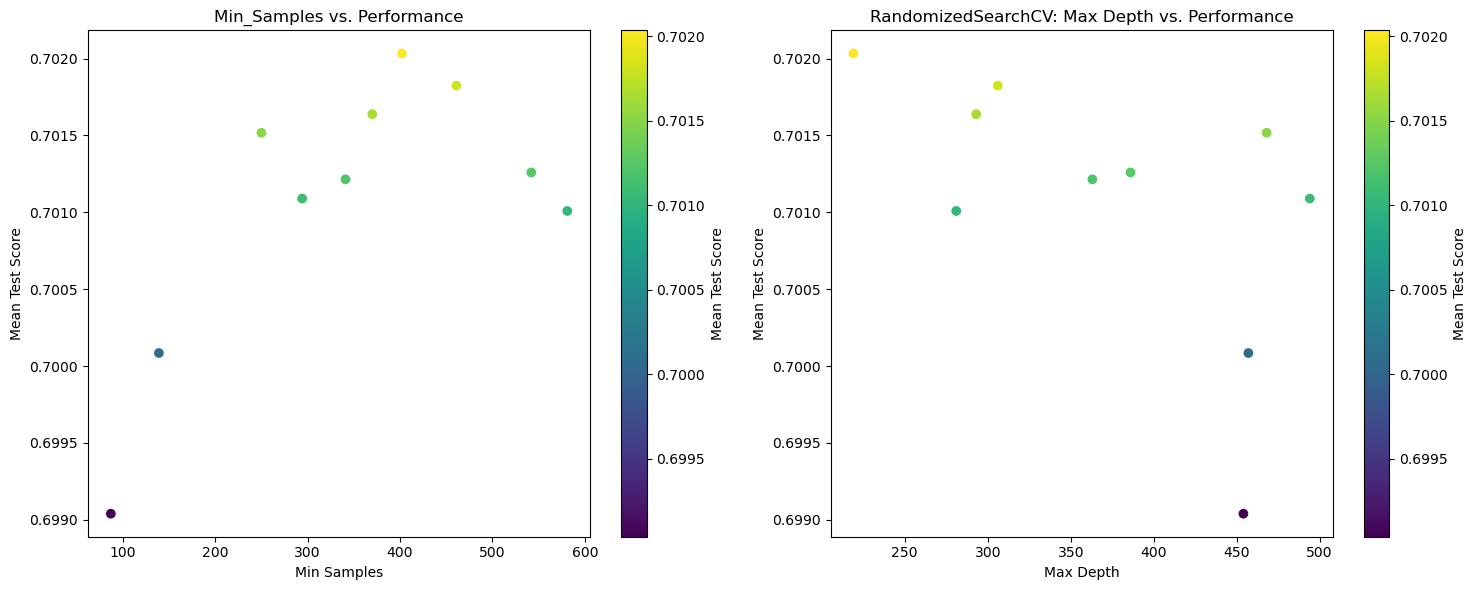

In [188]:
# Plot model performance by hyperparameters
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sc1 = ax[0].scatter(dt_rsv_results['param_dt_model__min_samples_leaf'], dt_rsv_results['mean_test_score'], c=dt_rsv_results['mean_test_score'], cmap='viridis')
ax[0].set_xlabel('Min Samples')
ax[0].set_ylabel('Mean Test Score')
fig.colorbar(sc1, ax=ax[0], label='Mean Test Score')
ax[0].set_title('Min_Samples vs. Performance')

sc2 = ax[1].scatter(dt_rsv_results['param_dt_model__max_depth'], dt_rsv_results['mean_test_score'], c=dt_rsv_results['mean_test_score'], cmap='viridis')
ax[1].set_xlabel('Max Depth')
ax[1].set_ylabel('Mean Test Score')
fig.colorbar(sc2, ax=ax[1], label='Mean Test Score')
ax[1].set_title('RandomizedSearchCV: Max Depth vs. Performance')

plt.tight_layout() 
plt.show()

Most of the hyperparameters seem to be doing reasonably well. We can narrow down this range further and use the narrowed range as the input to our new parameter grid for GridSearchCV. 

In [189]:
# extract top three model parameters
a = dt_rsv_results[0:3]['params'].values

# define lists with hyperparameter values
max_depth = []
min_samples_leaf = []
criterion = ['gini', 'entropy']

for i in range(len(a)):
    max_depth.append(a[i]['dt_model__max_depth'])
    min_samples_leaf.append(a[i]['dt_model__min_samples_leaf'])
    
print(max_depth)
print(min_samples_leaf)

[219, 306, 293]
[402, 461, 370]


**GridSearchCV**

In [190]:
# define parameter grid for gridsearchcv

dt_params = {
    'dt_model__max_depth': [250, 400, 425, 450, 475],
    'dt_model__min_samples_leaf': [400, 410, 420, 440, 450],
    'dt_model__criterion': ['gini']
}

# run gridsearchcv

dt_gsv = GridSearchCV(dt_pipe, param_grid=dt_params)
dt_gsv.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaling', StandardScaler()),
                                       ('dt_model', DecisionTreeClassifier())]),
             param_grid={'dt_model__criterion': ['gini'],
                         'dt_model__max_depth': [250, 400, 425, 450, 475],
                         'dt_model__min_samples_leaf': [400, 410, 420, 440,
                                                        450]})

In [191]:
# get best estimator
print(dt_gsv.best_estimator_)

# print test and training scores
print(dt_gsv.score(X_train, y_train))
print(dt_gsv.score(X_test, y_test))

# sorted results by ranking
results_grid = pd.DataFrame(dt_gsv.cv_results_).sort_values(by='rank_test_score').reset_index(drop=True)
display(results_grid.head(3))

# extract best hyperparameters
best_criterion = results_grid.head(1)['param_dt_model__criterion'].values[0]
best_depth = results_grid.head(1)['param_dt_model__max_depth'].values[0]
best_samples = results_grid.head(1)['param_dt_model__min_samples_leaf'].values[0]

Pipeline(steps=[('scaling', StandardScaler()),
                ('dt_model',
                 DecisionTreeClassifier(max_depth=250, min_samples_leaf=410))])
0.7077218051182691
0.7014935012513118


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dt_model__criterion,param_dt_model__max_depth,param_dt_model__min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.096519,0.018404,0.011484,0.000782,gini,250,410,"{'dt_model__criterion': 'gini', 'dt_model__max...",0.702652,0.699988,0.703399,0.702652,0.701966,0.702131,0.001164,1
1,1.122913,0.043818,0.014250,0.004315,gini,475,410,"{'dt_model__criterion': 'gini', 'dt_model__max...",0.702652,0.699988,0.703399,0.702652,0.701966,0.702131,0.001164,1
2,1.085863,0.040724,0.011984,0.000647,gini,400,410,"{'dt_model__criterion': 'gini', 'dt_model__max...",0.702652,0.699988,0.703399,0.702652,0.701966,0.702131,0.001164,1


Having identified our best model, we can now instantiate and fit this model separately so that we can interpret and evaluate it. 

In [192]:
# instantiate and fit best dt model

dt_best = DecisionTreeClassifier(max_depth = best_depth, min_samples_leaf = best_samples, criterion = best_criterion)
dt_best.fit(X_train_dt, y_train)

# get accuracy scores

print(f'Training Score of best model: {dt_best.score(X_train_dt, y_train)}')
print(f'Test Score of best model: {dt_best.score(X_test_dt, y_test)}')

Training Score of best model: 0.7077218051182691
Test Score of best model: 0.7014935012513118


Our model seems to have made a very slight improvement on our best logistic regression. However, we can proceed by interpreting the model feature importance, plotting the decision tree and printing a classification report to explore the model more thoroughly. 

In [193]:
# display feature importances
dt_feature_importance_df = pd.DataFrame({'Feature': X_train_dt.columns, 
                                      'Importance': dt_best.feature_importances_}).sort_values(by='Importance', ascending=False).reset_index(drop=True)
display(dt_feature_importance_df.T)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
Feature,p2002,p2004,age,p2000,g2002,median_age,totalpopulation_estimate,percent_65yearsandover,dem,highschool,percent_white,percent_18to64years,percent_female,treatment_neighbors,median_income,percent_black,percent_hispanicorlatino,less9thgrade,percent_amindian_alaskan,bach_orhigher,percent_under18years,unemploy_16,hh_size,percent_asian,percent_race_other,percent_other_nativeandother,g2000,treatment_self,percent_nativeandother,sex,treatment_hawthorne,treatment_civic duty
Importance,0.258298,0.2356,0.084985,0.073108,0.065571,0.036239,0.024646,0.02337,0.020084,0.018509,0.016207,0.014139,0.013795,0.013522,0.013148,0.012439,0.011896,0.011361,0.010922,0.008424,0.008055,0.007228,0.00506,0.003728,0.00335,0.002137,0.001668,0.001173,0.000869,0.000469,0.0,0.0


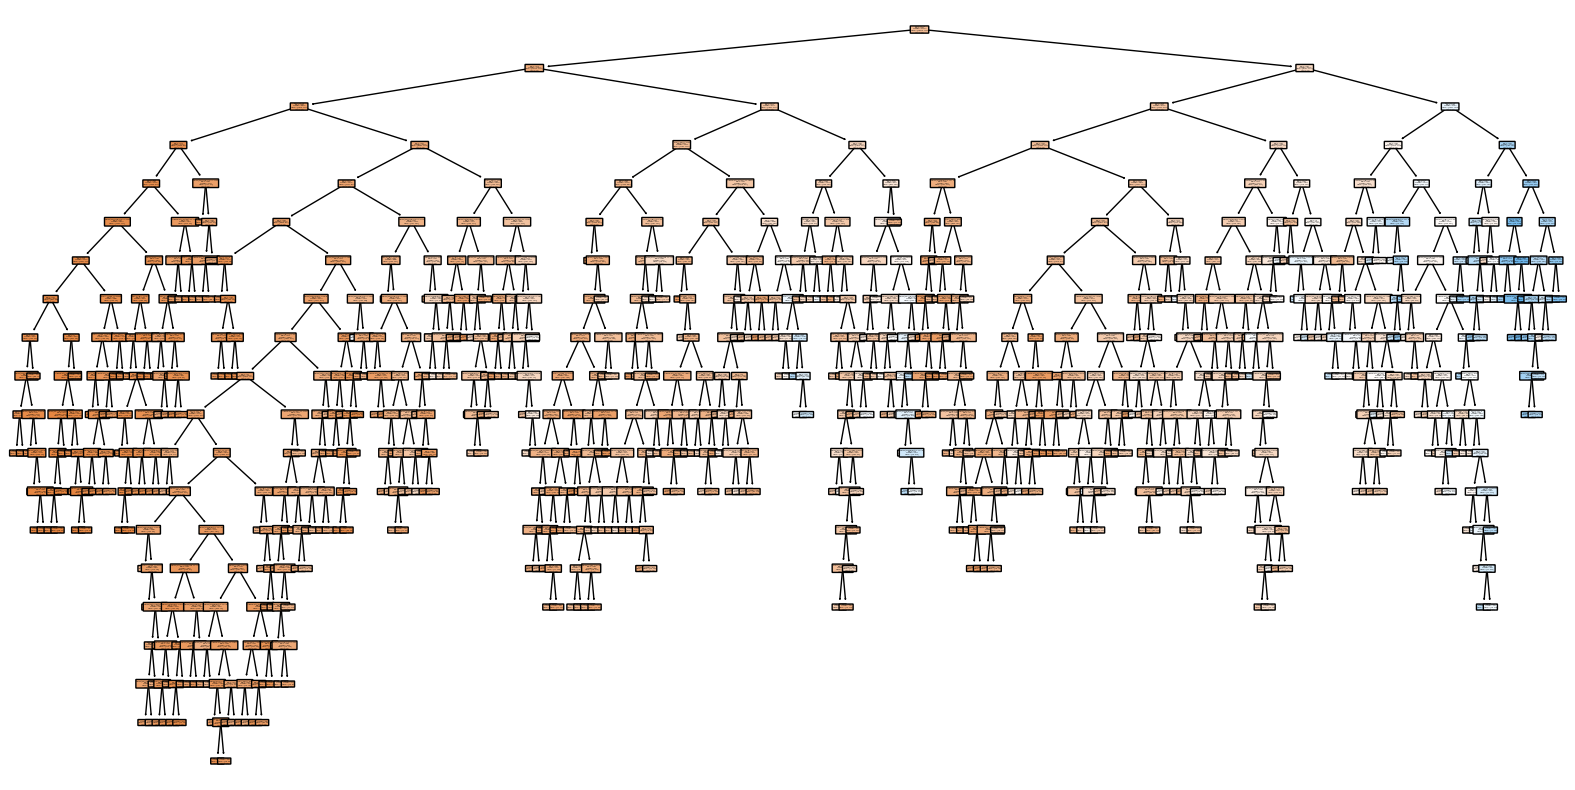

In [194]:
from sklearn.tree import plot_tree

# plot decision tree
plt.figure(figsize=(20,10))
plot_tree(dt_best, filled=True, feature_names=X_train_dt.columns, class_names=True, rounded=True)
plt.show()

In [196]:
# extract predictions 
y_pred_dt = dt_best.predict(X_test_dt)

# create classification report
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.72      0.93      0.81     42370
           1       0.57      0.21      0.31     19565

    accuracy                           0.70     61935
   macro avg       0.65      0.57      0.56     61935
weighted avg       0.67      0.70      0.65     61935



**Decision Tree Model Summary**

**Important Features:** Like our logistic regression models, this model places the highest importance on features associated with past voting behaviour. Age demographics are also crucial in predicting voting behavior. The model may be capturing the trend that voting likelihood varies with age, potentially due to differences in political engagement, availability, or motivation across age groups. Various demographic features like party affiliation ('dem'), education level ('highschool'), racial composition ('percent_white'), and gender ('percent_female') also significantly influence the model's predictions. 

**Model Evaluation:** The model has a precision of 0.72 for class 0 (did not vote), indicating a relatively high likelihood of correctly predicting non-voters. However, the precision for class 1 (voted) is lower at 0.57, suggesting that the model is less adept at correctly identifying voters. The recall for class 0 is high at 0.93, showing that the model is very effective at capturing the majority class. The recall for class 1 is much lower at 0.21, indicating that a large portion of actual voters are being missed by the model. The F1 score is good for class 0 at 0.81 but significantly lower for class 1 at 0.31. This discrepancy highlights the challenge the model faces in classifying the minority class effectively. The overall accuracy of the model is 0.70, which is around the same as for our best logistic regression models. 

Overall, it seems like the decision tree model suffers from the same problems with class imbalance as our logistic regression models. I have also included another decision tree model in the [appendix](#appendix) where `class_weight = 'balanced'` to account for this. This model drastically improved recall for voters and f1 score but reduced accuracy to ~0.63. 

### Random Forest <a id="random_forest"></a>

Given that our decision tree classifier did not make a substantial improvement compared to our baseline logistic regression models, we can use random forests, an ensemble learning approach, to enhance overall performance and robustness compared to a single decision tree. 

#### Random Forest Model 1: First Pass <a id="rf1"></a>

In [210]:
from sklearn.ensemble import RandomForestClassifier

# instantiate and fit random forest model 
rf = RandomForestClassifier(n_estimators = 50)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
Feature,age,dem,hh_size,sex,p2004,p2002,treatment_civic duty,treatment_hawthorne,treatment_self,p2000,g2002,g2000,median_age,median_income,percent_under18years,treatment_neighbors,totalpopulation_estimate,bach_orhigher,highschool,percent_65yearsandover,unemploy_16,percent_18to64years,percent_female,percent_hispanicorlatino,percent_white,less9thgrade,percent_black,percent_amindian_alaskan,percent_asian,percent_race_other,percent_other_nativeandother,percent_nativeandother
Importance,0.232297,0.214453,0.060642,0.042538,0.03067,0.025975,0.023592,0.023509,0.022833,0.019513,0.016297,0.016094,0.015601,0.015542,0.015451,0.015397,0.015386,0.015222,0.015166,0.015125,0.014962,0.014476,0.014434,0.013988,0.013926,0.013748,0.013581,0.013053,0.012352,0.012093,0.007665,0.004418


Training Score: 0.9964761443448777
Test Score: 0.6975377411802697


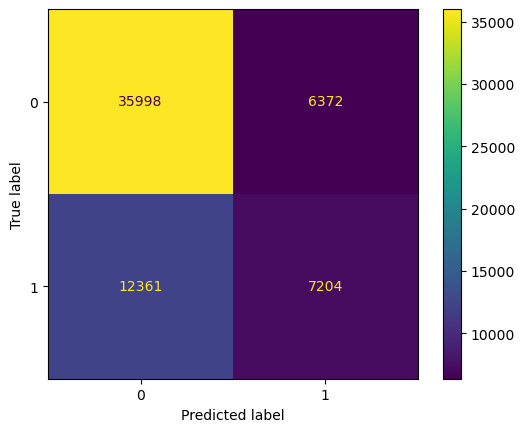

Confusion Matrix (DataFrame):


,Predicted Negative,Predicted Positive
True Negative,35998,6372
True Positive,12361,7204



Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.85      0.79     42370
           1       0.53      0.37      0.43     19565

    accuracy                           0.70     61935
   macro avg       0.64      0.61      0.61     61935
weighted avg       0.68      0.70      0.68     61935



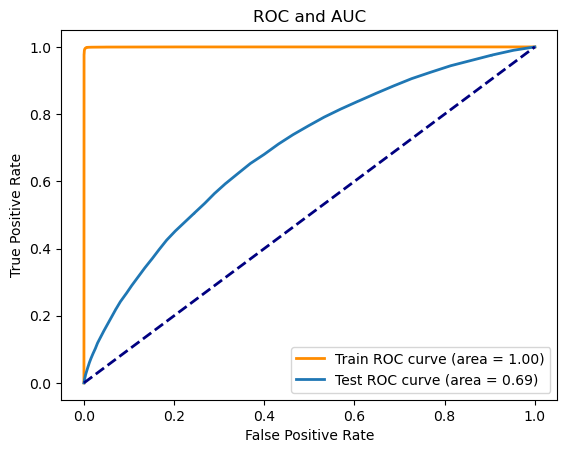

Test AUC score: 0.6924527942267567
Train AUC score: 0.9998818802986946


In [211]:
# get feature importances
rf_feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 
                                      'Importance': rf.feature_importances_}).sort_values(by='Importance', ascending=False).reset_index(drop=True)
display(rf_feature_importance_df.T)

# evaluate model 
u.evaluate_model(rf, X_train, y_train, X_test, y_test)

**Random Forest Model 1**

**Important Features:** Age is the most important feature, followed by `dem` (probability of voting democrat) and `hh_size` (household size). This is a departure from the most important features identified by previous models. The treatment variables also show up with moderate importance, indicating that the specific interventions or campaigns might have an influence, though not as strong as some of the demographic and historical features.

**Model Performance:**
- *Precision*: The Random Forest model has a precision of 0.74 for class 0 (did not vote), indicating a fairly high likelihood of correct predictions for non-voters. For class 1 (voted), the precision is lower at 0.53, which is an improvement over some of the logistic regression models.

- *Recall*: The recall for class 0 is 0.85, meaning the model is quite good at identifying non-voters, but it drops to 0.37 for class 1. Although not as high as desired, this is an improvement over the logistic regression models, particularly those without SMOTE.

- *F1-Score*: The F1-score, which combines precision and recall, is 0.79 for class 0 and 0.43 for class 1. These scores are higher compared to the F1-scores of most logistic regression models you have tested, indicating better performance for the Random Forest model in identifying both classes.

- *Accuracy*: The overall accuracy of 0.70 is similar to the logistic regression models.

Overall, our random forest model seems to be much better at detecting voters. This may indicate that the most important features in this model (age, household size, p(voting democrat)) are more predictive of voting behaviour and useful characteristics to identify subgroups. However, the model seems to be overfitting quite drastically. 

#### Random Forest Model 2: Tuned Model w/ Balanced Class Weight and StratifiedKFold <a id="rf2"></a>

This random forest model using RandomizedSearchCV to perform some rough hyperparameter tuning. More importantly, this model is aimed at optimising f1 score and addressing the class imbalance using the `class_weight='balanced'` argument and StratifiedKFold cross validation. 

In [212]:
# run randomizedsearchCV
from sklearn.model_selection import StratifiedKFold

# create pipeline
rf2_estimators = [('rf_classifier', RandomForestClassifier(class_weight='balanced'))]
rf2_pipe = Pipeline(rf2_estimators)

# create parameter grid 
rf2_param_grid = {
    'rf_classifier__max_depth': list(range(2, 500)),
    'rf_classifier__min_samples_leaf': list(range(2500, 5000)),
    'rf_classifier__min_samples_split': list(range(2, 1000)) }

# define cross validator 
rf2_cv = StratifiedKFold(n_splits=5)

# initialise and fit randomizedsearchCV
rsv_rf2 = RandomizedSearchCV(rf2_pipe, rf2_param_grid, cv=rf2_cv, scoring='f1', verbose=0)
rsv_rf2.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('rf_classifier',
                                              RandomForestClassifier(class_weight='balanced'))]),
                   param_distributions={'rf_classifier__max_depth': [2, 3, 4, 5,
                                                                     6, 7, 8, 9,
                                                                     10, 11, 12,
                                                                     13, 14, 15,
                                                                     16, 17, 18,
                                                                     19, 20, 21,
                                                                     22, 23, 24,
                                                                     25, 26, 27,
                                                                     28, 29, 30,
                                                                     31, ...],
                                        'rf_classifier__min_samples_leaf': [2500,
                                                                            2501,
                                                                            2502,
                                                                            2503,
                                                                            2504,
                                                                            2505,
                                                                            2506,
                                                                            2507,
                                                                            2508,
                                                                            2509,
                                                                            2510,
                                                                            2511,
                                                                            2512,
                                                                            2513,
                                                                            2514,
                                                                            2515,
                                                                            2516,
                                                                            2517,
                                                                            2518,
                                                                            2519,
                                                                            2520,
                                                                            2521,
                                                                            2522,
                                                                            2523,
                                                                            2524,
                                                                            2525,
                                                                            2526,
                                                                            2527,
                                                                            2528,
                                                                            2529, ...],
                                        'rf_classifier__min_samples_split': [2,
                                                                             3,
                                                                             4,
                                                                             5,
                                                                             6,
                                                                             7,


In [213]:
# print results of randomized search
rsv_rf2_results_df = pd.DataFrame(rsv_rf2.cv_results_).sort_values(by='rank_test_score').reset_index(drop=True)
display(rsv_rf2_results_df.head(3))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf_classifier__min_samples_split,param_rf_classifier__min_samples_leaf,param_rf_classifier__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,8.011774,0.178868,0.248237,0.005376,826,2883,18,"{'rf_classifier__min_samples_split': 826, 'rf_...",0.524348,0.521237,0.525172,0.521036,0.526930,0.523745,0.002288,1
1,8.105543,0.367318,0.249105,0.007007,226,3429,47,"{'rf_classifier__min_samples_split': 226, 'rf_...",0.525609,0.522439,0.523294,0.522880,0.524313,0.523707,0.001135,2
2,8.331325,0.254504,0.254327,0.006574,468,2848,277,"{'rf_classifier__min_samples_split': 468, 'rf_...",0.524798,0.521758,0.524569,0.520871,0.526363,0.523672,0.002041,3


In [219]:
# extract best hyperparameters
rf2_best_max_depth = rsv_rf2_results_df.head(1)['param_rf_classifier__max_depth'][0]
rf2_best_min_samples_split = rsv_rf2_results_df.head(1)['param_rf_classifier__min_samples_split'][0]
rf2_best_min_samples_leaf = rsv_rf2_results_df.head(1)['param_rf_classifier__min_samples_leaf'][0]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
Feature,p2004,p2002,g2002,age,p2000,g2000,percent_under18years,median_age,hh_size,percent_65yearsandover,highschool,bach_orhigher,treatment_neighbors,median_income,totalpopulation_estimate,dem,percent_asian,percent_hispanicorlatino,less9thgrade,unemploy_16,percent_black,percent_amindian_alaskan,percent_18to64years,percent_female,percent_race_other,percent_white,percent_other_nativeandother,percent_nativeandother,treatment_self,sex,treatment_hawthorne,treatment_civic duty
Importance,0.251294,0.222727,0.138873,0.123944,0.074038,0.023033,0.018947,0.018564,0.017562,0.017313,0.011063,0.010667,0.007582,0.006644,0.006589,0.006568,0.006392,0.004948,0.004913,0.004813,0.004305,0.003651,0.003511,0.003381,0.003197,0.002649,0.001917,0.000424,0.000337,0.000153,0.0,0.0


Training Score: 0.608064906757084
Test Score: 0.6023088722047307


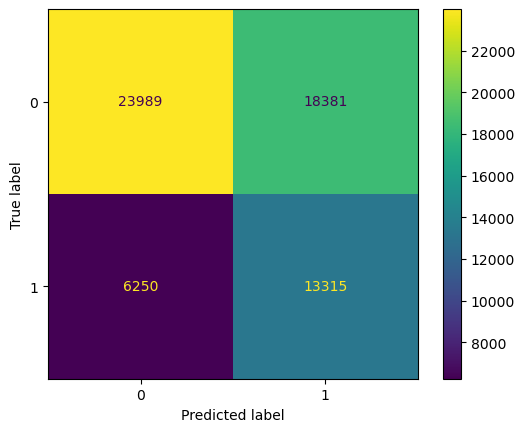

Confusion Matrix (DataFrame):


,Predicted Negative,Predicted Positive
True Negative,23989,18381
True Positive,6250,13315



Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.57      0.66     42370
           1       0.42      0.68      0.52     19565

    accuracy                           0.60     61935
   macro avg       0.61      0.62      0.59     61935
weighted avg       0.68      0.60      0.62     61935



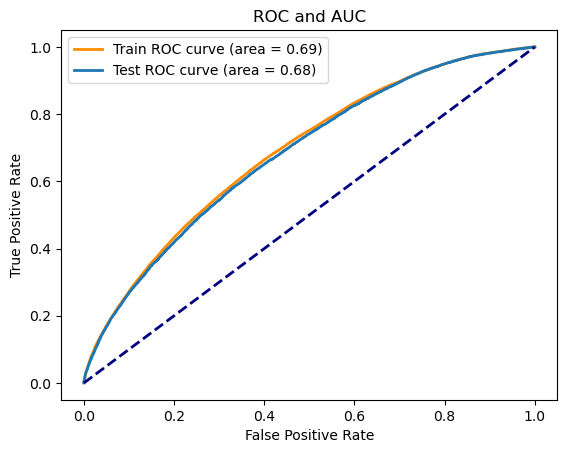

Test AUC score: 0.6813687133433992
Train AUC score: 0.6880841879853999


In [220]:
# instantiate and fit best model 
rf2_best = RandomForestClassifier(max_depth=rf2_best_max_depth, 
                                  min_samples_split=rf2_best_min_samples_split, 
                                  min_samples_leaf = rf2_best_min_samples_leaf,
                                  class_weight='balanced')
rf2_best.fit(X_train, y_train)

# print feature importance dataframe
rf2_feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 
                                      'Importance': rf2_best.feature_importances_}).sort_values(by='Importance', ascending=False).reset_index(drop=True)
display(rf2_feature_importance_df.T)

# print model evaluation
u.evaluate_model(rf2_best, X_train, y_train, X_test, y_test)

**Model Performance:**
- *Precision*: The model has a precision of 0.79 for class 0 (did not vote), a respectable figure that suggests a high likelihood of correct non-voter predictions. However, for class 1 (voted), the precision is lower at 0.42, indicating almost half of the positive predictions are false positives.

- *Recall*: The model has significantly improved recall for class 1, at 0.68, which indicates that it is much better at identifying voters than the previous Random Forest model. However, recall for class 0 has decreased to 0.57, suggesting a compromise where the model is now missing a portion of the non-voters it used to identify.

- *F1-Score*: For class 0, it's 0.66, and for class 1, it's 0.52. While the F1 score for class 1 has improved, reflecting better balance, it comes at the expense of the F1 score for class 0.

- *Accuracy*: The overall accuracy of 0.60 is lower than the previous models, which is expected given the model is now designed to favor the minority class, potentially leading to more false positives for the majority class.

The optimized Random Forest model has achieved its goal of improving recall for the minority class (voted). There is a trade-off, however, as this model has a lower precision for the minority class and lower recall for the majority class. The overall accuracy is also lower, reflecting the focus on recall at the expense of other metrics.

### Gradient Boosting <a id="gradient_boosting"></a>

Another ensemble learning approach is to use 'boosting' instead of 'bagging' (like in the case of random forest models). This approach focuses on sequentially building models where each subsequent model aims to correct the mistakes of previous models. This approach may be promising in improving performance on the minority class if those are the instances where previous models in the sequence make errors. 

In [230]:
from sklearn.ensemble import GradientBoostingClassifier

# instantiate and fit model 
gbc = GradientBoostingClassifier(learning_rate=1)
gbc.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
Feature,p2002,p2004,age,p2000,g2002,median_age,highschool,totalpopulation_estimate,percent_18to64years,less9thgrade,median_income,percent_65yearsandover,percent_female,percent_hispanicorlatino,percent_black,bach_orhigher,dem,treatment_neighbors,unemploy_16,percent_amindian_alaskan,percent_under18years,percent_white,percent_asian,percent_other_nativeandother,percent_nativeandother,hh_size,treatment_self,g2000,percent_race_other,treatment_hawthorne,treatment_civic duty,sex
Importance,0.220366,0.193404,0.083739,0.05396,0.052944,0.032076,0.030994,0.030805,0.023904,0.021393,0.020642,0.020222,0.019276,0.019245,0.018909,0.018822,0.018186,0.017377,0.015138,0.014212,0.013137,0.011525,0.00962,0.00817,0.007862,0.006721,0.006276,0.00407,0.003703,0.001776,0.001159,0.00037


Training Score: 0.7227819488173085
Test Score: 0.7116977476386535


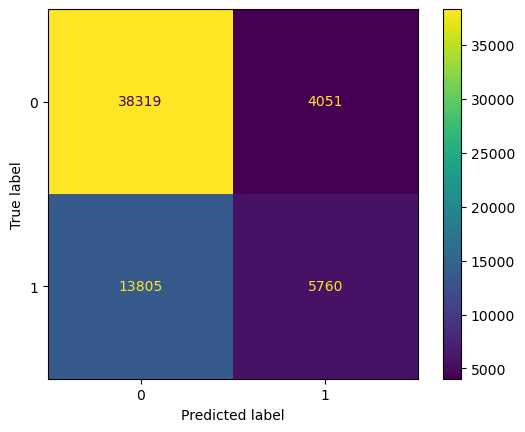

Confusion Matrix (DataFrame):


,Predicted Negative,Predicted Positive
True Negative,38319,4051
True Positive,13805,5760



Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.90      0.81     42370
           1       0.59      0.29      0.39     19565

    accuracy                           0.71     61935
   macro avg       0.66      0.60      0.60     61935
weighted avg       0.69      0.71      0.68     61935



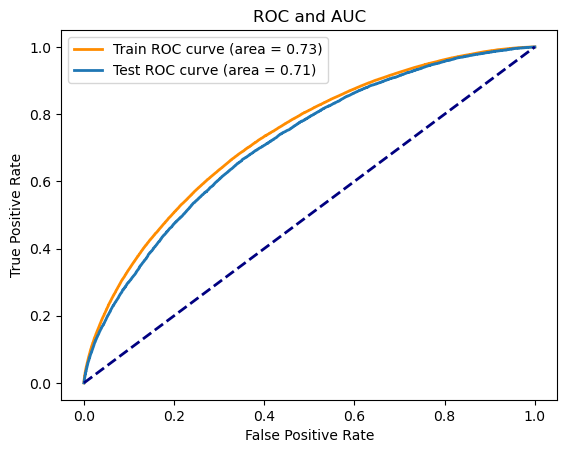

Test AUC score: 0.7147743652190635
Train AUC score: 0.7330908032083664


In [231]:
# print feature importance
gbc_feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 
                                      'Importance': gbc.feature_importances_}).sort_values(by='Importance', ascending=False).reset_index(drop=True)
display(gbc_feature_importance_df.T)

# evaluate model 
u.evaluate_model(gbc, X_train, y_train, X_test, y_test)

**Gradient Boosting Classifier Model Summary**

**Model Performance**
- *Precision and Recall*: The gradient boosting model achieves a precision of 0.74 for class 0 (did not vote) and 0.59 for class 1 (voted), with recalls of 0.90 and 0.29, respectively. This indicates a strong ability to identify non-voters correctly but a moderate capacity for correctly identifying voters.

- *F1-Score*: The F1-score is relatively high for class 0 at 0.81 but lower for class 1 at 0.39. This means the model is still struggling with class imbalance. 

- *Accuracy*: The overall accuracy of 0.71 is comparable to or slightly better than some of the previous models we have tested.

Overall, this gradient boosting model appears to perform similarly to your Random Forest models in terms of accuracy and precision for the majority class but struggles with recall for the minority class. However, its recall for class 1 is substantially lower than the Random Forest model optimized for recall.

### Neural Network <a id="neural_network"></a>

Our last modelling attempt involves building a simple, dense neural network. This may improve on our modelling attempts so far as neural network have the capacity to learn feature interactions automatically without manually creating interaction terms as in traditional models.

In [237]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout

# Define features
X_train_dnn = X_train_s.copy()
X_test_dnn = X_test_s.copy()

# Define input shape
input_shape = X_train_s.shape[1]

# Define model
dnn = tf.keras.Sequential([
    Dense(64, activation='relu', input_shape=(input_shape,)),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile model
dnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
dnn.fit(X_train_s, y_train, epochs=100, batch_size=32, validation_data=(X_test_s, y_test), verbose=0)

In [246]:
# evaluate model
evaluate_binary_classification(dnn, X_test_dnn, y_test)

1936/1936 [==============================] - 0s 240us/step


{'class_0': {'precision': 0.7304485309341414,
  'recall': 0.9159310833136654,
  'f1_score': 0.8127414946753369},
 'class_1': {'precision': 0.5955030660913014,
  'recall': 0.26802964477383084,
  'f1_score': 0.36967325790419797},
 'accuracy': 0.7112618067328651}

**Neural Network Model**

**Model Performance**
Compared to traditional models, this neural network shows a pattern consistent with previous findings: strong performance on the majority class (did not vote) but difficulties in accurately capturing the minority class (voted). This is evident from the high recall for class 0 and much lower recall for class 1. The accuracy of this model is comparable to, or slightly better than, some of the other models we've tested, like Random Forest and gradient boosting models. However, like those models, the neural network also struggles with balancing recall across both classes. The precision and recall for class 1 suggest this model, like the others, faces challenges with the class imbalance inherent in the dataset. There is an additional complication with neural networks which is that interpretation of the importance of specific features is less straightforward. 

## Conclusions <a id="conclusions"></a>

#### Notebook Overview

In this notebook we have done some feature engineering by dropping/creating new features, advanced EDA using clustering, and explored various modelling approaches to answer our key research question, **'How might we use machine learning to understand the role of social pressure in influencing voting behaviour?'**

#### Model Summaries
			            

| Model Name           | Accuracy | Precision* | Recall* | F1 Score* |
|----------------------|----------|-----------|--------|----------|
| LogReg: SMOTE        | 0.57 | 0.37 |0.50| 0.43 |
| LogReg: GridSearchCV | 0.70 | 0.57 |0.19| 0.28 |
| DT: Tuned            | 0.70 | 0.57 |0.21| 0.31 |
| RF: First Pass       |     0.70     |      0.53     |    0.37    |      0.43    |
| RF: Class Balance    |     0.60     |     0.42      |     0.68   |      0.52    |
| Gradient Boosting    |     0.71     |      0.59     |    0.29    |     0.39     |
| Neural Network       |     0.71     |     0.60      |   0.27     |     0.36     |

\*These are all evaluation metrics for Class 1 (voted). 

Overall, **ensemble learning** approaches combined with methods to address class imbalance seem the most promising in helping us achieve higher accuracy without compromising on recall for the minority class. These approaches and others will be developed further in following notebooks. 

#### Next steps

1. To enhance the interpretability of neural networks and other models, I plan to utilize SHAP (SHapley Additive exPlanations) values and other evaluation metrics. These tools will offer deeper insights into how features influence model predictions, providing a more granular understanding of model behavior.

2. I will explore additional class balancing techniques, including more extensive use of SMOTE and other strategies to address class imbalance. 

3. An expanded hyperparameter tuning process will be undertaken to optimize model performance further. 

4. I intend to employ causal forest models to estimate conditional average treatment effects. This approach will help in providing insights into causality that standard models might not reveal.

5. I intend to integrate my clustering analysis into my modelling approach to more accurately estimate the differential impact of the treatments on subgroups in the population.

6. For models that have low recall but are otherwise promising, I aim to extract the false negatives and examine their characteristics to look for systematic issues in the data that may be causing low recall scores. I may then apply further feature engineering to solve these issues, should they exist. 

## Appendix <a id="appendix"></a>

#### Data Dictionary

**Treatment**

| Column Name | Description                                         |
|-------------|-----------------------------------------------------|
| treatment   | type of treatment (or none) received                |


**Outcome**

| Column Name | Description                                         |
|-------------|-----------------------------------------------------|
| voted       | Did they vote or not in the August 2006 primary election? |
| votedav     | Absentee voting                          |

**Voting Information**

| Column Name | Description                                 |
|-------------|---------------------------------------------|
| g2000       | Voted in the 2000 general election          |
| g2002       | Voted in the 2002 general election          |
| g2004       | Voted in the 2004 general election          |
| p2000       | Voted in the 2002 primary election          |
| p2002       | Voted in the 2002 primary election          |
| p2004       | Voted in the 2004 primary election          |
| dem         | Likelihood of voting democrat |


**Demographic Information (Age/Gender)**

| Column Name             | Description                                      |
|-------------------------|--------------------------------------------------|
| sex                     | Sex of the individual (1 if female, 0 if male)                          |
| yob                     | Year of birth of the individual                  |
| percent_male            | Percentage of males in ZIP code                  |
| percent_female          | Percentage of females in ZIP code                |
| median_age              | Median age in ZIP code                           |
| percent_under5years     | Percentage of individuals under 5 in ZIP code    |
| percent_5to9years       | Percentage of individuals between 5 and 9 in ZIP code |
| percent_10to14years     | Percentage of individuals between 10 and 14 in ZIP code |
| percent_15to19years     | Percentage of individuals between 15 and 19 in ZIP code |
| percent_20to24years     | Percentage of individuals between 20 and 24 in ZIP code |
| percent_25to34years     | Percentage of individuals between 25 and 34 in ZIP code |
| percent_35to44years     | Percentage of individuals between 35 and 44 in ZIP code |
| percent_45to54years     | Percentage of individuals between 45 and 54 in ZIP code |
| percent_55to59years     | Percentage of individuals between 55 and 59 in ZIP code |
| percent_60to64years     | Percentage of individuals between 60 and 64 in ZIP code |
| percent_65to74years     | Percentage of individuals between 65 and 74 in ZIP code |
| percent_75to84years     | Percentage of individuals between 75 and 84 in ZIP code |
| percent_85yearsandolder | Percentage of individuals 85 years and older in ZIP code |
| percent_18yearsandolder | Percentage of individuals 18 years and older in ZIP code |
| percent_21yearsandover  | Percentage of individuals 21 years and over in ZIP code |
| percent_62yearsandover  | Percentage of individuals 62 years and over in ZIP code |
| percent_65yearsandover  | Percentage of individuals 65 years and over in ZIP code |

**Demographic Information (Race)**
| Column Name                     | Description                                                                 |
|---------------------------------|-----------------------------------------------------------------------------|
| percent_white                   | Percentage of individuals who are white in ZIP code                         |
| percent_black                   | Percentage of individuals who are black/African-American in ZIP code        |
| percent_amindian_alaskan        | Percentage of individuals who are American Indian or Alaska Natives in ZIP code |
| percent_asian                   | Percentage of individuals who are Asian in ZIP code                         |
| percent_nativeandother          | Percentage of individuals who are Native Hawaiian or Other Pacific Islander in ZIP code |
| percent_other_nativeandother    | Percentage of individuals who are white in ZIP code                         |
| percent_hispanicorlatino        | Percentage of individuals who are of Hispanic or Latino origin in ZIP code  |
| percent_race_other              | Percentage of individuals who are of another race not above in ZIP code     |


**Demographic Information (Income and Employment)**
| Column Name             | Description                                                                 |
|-------------------------|-----------------------------------------------------------------------------|
| median_income           | Median income of ZIP code                                                   |
| mean_income             | Mean income of ZIP code                                                     |
| employ_16               | Proportion of population in ZIP code that is 16 years and over and employed |
| unemploy_16             | Proportion of population in ZIP code that is 16 years and over and unemployed |
| unemploy_20to64         | Proportion of population in ZIP code that is between 20 and 64 years and unemployed |
| employ_20to64           | Proportion of population in ZIP code that is between 20 and 64 years and employed |


**Demographic Information (Education)**

| Column Name       | Description                                                                          |
|-------------------|--------------------------------------------------------------------------------------|
| hsorhigher        | Percentage of population in ZIP code that have high school education or higher       |
| bach_orhigher     | Percentage of population in ZIP code that have bachelors degree or higher            |
| less9thgrade      | Percentage of population in ZIP code that have less than 9th grade education         |
| grade9to12        | Percentage of population in ZIP code that have 9-12th grade education, no diploma    |
| highschool        | Percentage of population in ZIP code that are high school graduates                  |
| somecollege       | Percentage of population in ZIP code that have some college, no degree               |
| assoc             | Percentage of population in ZIP code that have an associate’s degree                 |
| bachelors         | Percentage of population in ZIP code that have a bachelor’s degree                   |
| grad              | Percentage of population in ZIP code that have a graduate or professional degree     |


**Demographic Information (Location and Household)**

| Column Name                 | Description                                                                       |
|-----------------------------|-----------------------------------------------------------------------------------|
| zip                         | ZIP code (693 total)                                                              |
| city                        | City ID (101 total)                                                               |
| hh_id                       | Household ID for all 180,002 households                                           
| hh_size                     | Number of people in household                                                     |
| CityName                    | Name of the city                                                                  |
| totalpopulation_estimate    | Estimate of total population in ZIP code                                          |
| cluster                     | Which cluster is this household in? (1-10,000)                                    |


One note on the level of granularity of our dataset: each rows contains data about the treatment status of an individual (`treatment`), whether or not they voted in the 2006 Primary Election (`voted`) and other details. Each row also contains census data about the demographic characteristics of the ZIP code in which the individual resides.

#### Function: Model Evaluation

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_curve, roc_auc_score

def evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    Evaluate a fitted model on training and test data with various metrics.
    
    Parameters:
    - model: The fitted model to evaluate.
    - X_train: Features for the training data.
    - y_train: Target for the training data.
    - X_test: Features for the test data.
    - y_test: Target for the test data.
    
    Outputs:
    - Training accuracy.
    - Test accuracy.
    - A confusion matrix display.
    - Confusion matrix in DataFrame format.
    - Classification report.
    - ROC curve.
    - Test AUC score.
    - Train AUC score.
    """
    # Training and test accuracy
    print(f'Training Score: {model.score(X_train, y_train)}')
    print(f'Test Score: {model.score(X_test, y_test)}')
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    
    # Confusion Matrix Display
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
    plt.show()  # Display the plot immediately
    
    # Confusion Matrix DataFrame
    confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred),
                                       columns=['Predicted Negative', 'Predicted Positive'], 
                                       index=['True Negative', 'True Positive'])
    print("Confusion Matrix (DataFrame):")
    display(confusion_matrix_df)
    
    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # ROC Curve and AUC
    y_proba_test = model.predict_proba(X_test)[:, 1]
    y_proba_train = model.predict_proba(X_train)[:, 1]
    fprs, tprs, _ = roc_curve(y_test, y_proba_test)
    roc_auc = roc_auc_score(y_test, y_proba_test)
    fprs_train, tprs_train, _ = roc_curve(y_train, y_proba_train)
    roc_auc_train = roc_auc_score(y_train, y_proba_train)
    
    plt.figure()
    plt.plot(fprs_train, tprs_train, color='darkorange', lw=2, label=f'Train ROC curve (area = {roc_auc_train:.2f})')
    plt.plot(fprs, tprs, lw=2, label=f'Test ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC and AUC')
    plt.legend(loc="best")
    plt.show()
    
    print(f"Test AUC score: {roc_auc}")
    print(f"Train AUC score: {roc_auc_train}")

#### Function: Find Correlated Pairs

In [ ]:
def find_correlated_pairs(corr_matrix, threshold):
    """
    Find pairs of features in the correlation matrix where the absolute value
    of the correlation coefficient is greater than a specified threshold.
    
    Parameters:
    - corr_matrix: A pandas DataFrame representing the correlation matrix.
    - threshold: A float representing the threshold for the absolute value of the correlation coefficient.
    
    Returns:
    - A list of tuples, where each tuple contains a pair of feature names and their correlation coefficient,
      with the absolute value of the coefficient greater than the threshold. Each pair is returned once,
      ignoring self-correlations.
    """
    correlated_pairs = []
    
    # Iterate over the upper triangle of the correlation matrix
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            # Check if the absolute correlation coefficient exceeds the threshold
            if abs(corr_matrix.iloc[i, j]) > threshold:
                # Append the pair and the correlation coefficient to the list
                correlated_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))
                
    return correlated_pairs

#### Function: Extract and Display Coefficients

In [ ]:
def get_model_coefficients(training_set, model):
    """
    Generate a DataFrame with feature names, their corresponding coefficients from a logistic regression model,
    the absolute value of these coefficients, and the odds ratios.
    
    Parameters:
    - training_set: A DataFrame containing features.
    - model: A fitted logistic regression model object from scikit-learn.
    
    Returns:
    - DataFrame: A DataFrame sorted by the absolute values of the coefficients in descending order.
                 The DataFrame contains columns for feature names, coefficients, absolute coefficients, and odds ratios.
    """
    
    # Create a DataFrame with feature names and their coefficients
    coef_df = pd.DataFrame({
        'Feature': training_set.columns,
        'Coefficients': model.coef_[0]
    })
    
    # Calculate the absolute value of coefficients
    coef_df['Absolute Coef'] = np.abs(coef_df['Coefficients'])
    
    # Calculate the odds ratios
    coef_df['Odds_Ratio'] = np.exp(coef_df['Coefficients'])
    
    # Sort by absolute value of coefficients, descending
    coef_df_sorted = coef_df.sort_values('Absolute Coef', ascending=False).reset_index(drop=True)
    
    return coef_df_sorted.T

#### Function: Summarise LogReg Models

In [ ]:
def summarize_lr_models(model_names, models, train_sets, test_sets, y_train_list, y_test_list):
    """
    Summarizes and compares pre-fitted logistic regression models.
    
    Parameters:
    - model_names: A list of names (strings) assigned to each model.
    - models: A list of pre-fitted logistic regression model objects.
    - train_sets: A list of training sets corresponding to each model.
    - test_sets: A list of test sets corresponding to each model.
    - y_train_list: A list of training labels.
    - y_test_list: A list of test labels.
    
    Returns:
    - DataFrame: A pandas DataFrame containing the summary of each model.
    """
    # Import metrics libraries
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    
    # Initialize a list to store each model's summary
    summaries = []
    
    # Iterate over each model and its corresponding datasets
    for model_name, model, X_train, X_test, y_train, y_test in zip(model_names, models, train_sets, test_sets, y_train_list, y_test_list):
        # Compute the number of features
        num_features = X_train.shape[1]
        
        # List containing all the feature names
        feature_names = list(X_train.columns)
        
        # Make predictions on both the training and test sets
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        # Calculate accuracy, precision, recall, and f1 score
        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        precision = precision_score(y_test, y_test_pred)
        recall = recall_score(y_test, y_test_pred)
        f1 = f1_score(y_test, y_test_pred)
        
        # Calculate AUC score
        # Note: roc_auc_score expects probability scores for the positive class
        y_test_prob = model.predict_proba(X_test)[:, 1]
        auc_score = roc_auc_score(y_test, y_test_prob)
        
        # Append the summary for the current model to the summaries list
        summaries.append([model_name, num_features, feature_names, train_accuracy, test_accuracy, precision, recall, f1, auc_score])
    
    # Convert the summaries list into a DataFrame
    summary_df = pd.DataFrame(summaries, columns=['Model Name', 'Number of Features', 'Feature Names', 'Training Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC Score'])
    
    return summary_df

#### Function: Evaluate Neural Network Model

In [245]:
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

def evaluate_binary_classification(model, X_test, y_test):
    """
    Evaluates a binary classification neural network model on the test set.
    
    Args:
    - model: The trained neural network model.
    - X_test: Test features.
    - y_test: True labels for the test set.
    
    Returns:
    - A dictionary containing accuracy, precision, recall, and F1 score for both classes.
    """
    # Get model predictions
    y_pred_prob = model.predict(X_test)
    # Convert probabilities to binary predictions
    y_pred = np.where(y_pred_prob >= 0.5, 1, 0).flatten()
    
    # Calculate metrics
    report = classification_report(y_test, y_pred, output_dict=True)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Extract metrics for both classes and overall accuracy
    metrics = {
        "class_0": {
            "precision": report['0']['precision'],
            "recall": report['0']['recall'],
            "f1_score": report['0']['f1-score']
        },
        "class_1": {
            "precision": report['1']['precision'],
            "recall": report['1']['recall'],
            "f1_score": report['1']['f1-score']
        },
        "accuracy": accuracy
    }
    
    return metrics

#### Choosing Optimal K for SelectKBest

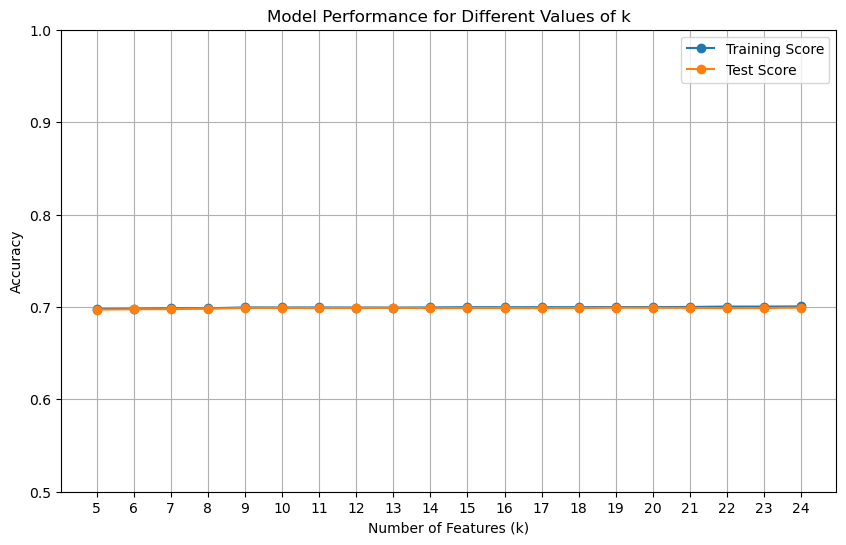

In [40]:
from sklearn.metrics import accuracy_score
# Initialize lists to store training and test scores
train_scores = []
test_scores = []

# Range of k values to iterate over
k_values = range(5, 25)

for k in k_values:
    # Apply SelectKBest to select the top k features
    skb = SelectKBest(k=k)
    skb.fit(X_train_s, y_train)
    
    # Transform train and test sets to keep only the selected features
    X_train_selected = skb.transform(X_train_s)
    X_test_selected = skb.transform(X_test_s)
    
    # Fit logistic regression model with the selected features
    lr = LogisticRegression(max_iter=1000)  # Increase max_iter if needed
    lr.fit(X_train_selected, y_train)
    
    # Predict and calculate accuracy for both train and test sets
    train_pred = lr.predict(X_train_selected)
    test_pred = lr.predict(X_test_selected)
    train_accuracy = accuracy_score(y_train, train_pred)
    test_accuracy = accuracy_score(y_test, test_pred)
    
    # Append the accuracies to their respective lists
    train_scores.append(train_accuracy)
    test_scores.append(test_accuracy)

# Plotting the training and test scores
plt.figure(figsize=(10, 6))
plt.plot(k_values, train_scores, label='Training Score', marker='o')
plt.plot(k_values, test_scores, label='Test Score', marker='o')
plt.title('Model Performance for Different Values of k')
plt.xlabel('Number of Features (k)')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.legend()
plt.ylim(0.5, 1)
plt.grid(True)
plt.show()

#### `nov` and `aug`

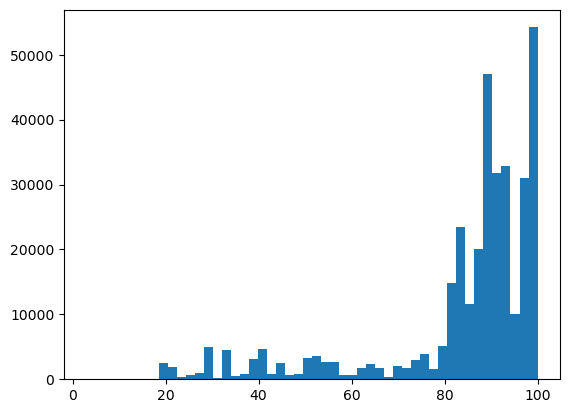

In [94]:
# plot distribution of nov
plt.hist(data['nov'], bins =50);

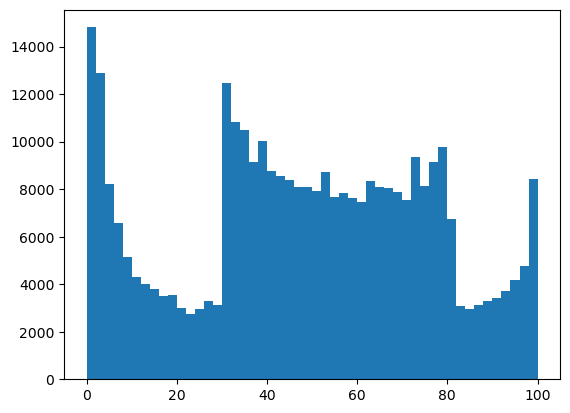

In [95]:
# plot distribution of aug
plt.hist(data['aug'], bins =50);

In [96]:
# correlation matrix
data[['nov', 'aug', 'g2000', 'g2002', 'p2000', 'p2002']].corr()

,nov,aug,g2000,g2002,p2000,p2002
nov,1.000000,0.564705,0.436665,0.774745,0.085261,0.168416
aug,0.564705,1.000000,0.347095,0.450771,0.352958,0.440073
g2000,0.436665,0.347095,1.000000,0.404395,0.174615,0.148716
g2002,0.774745,0.450771,0.404395,1.000000,0.112304,0.240244
p2000,0.085261,0.352958,0.174615,0.112304,1.000000,0.099628
p2002,0.168416,0.440073,0.148716,0.240244,0.099628,1.000000


#### DecisionTreeClassifier with class_weight='balanced'

In [199]:
# decision tree classifier with class_weight='balanced'

dt_class_weight = DecisionTreeClassifier(max_depth = best_depth, min_samples_leaf = best_samples, criterion = best_criterion, class_weight='balanced')
dt_class_weight.fit(X_train_dt, y_train)

# get accuracy scores

print(f'Training Score: {dt_class_weight.score(X_train_dt, y_train)}')
print(f'Test Score: {dt_class_weight.score(X_test_dt, y_test)}')

# extract predictions 
y_pred_dt_class = dt_class_weight.predict(X_test_dt)

# create classification report
print(classification_report(y_test, y_pred_dt_class))

Training Score: 0.6404335190118673
Test Score: 0.6253168644546703
              precision    recall  f1-score   support

           0       0.79      0.62      0.69     42370
           1       0.44      0.65      0.52     19565

    accuracy                           0.63     61935
   macro avg       0.61      0.63      0.61     61935
weighted avg       0.68      0.63      0.64     61935

